In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from scipy.optimize import curve_fit

from typing import Literal, Union

from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import matplotlib as mpl

from qs_mps.utils import create_sequential_colors
from qs_mps.applications.Z2.utils import get_cx, get_cy, find_closest_value, asymptotic_fit, plot_asymptotic_fit
from qs_mps.applications.Z2.relevant_observables import static_potential, static_potential_chis, static_potential_exact_L, static_potential_Ls
# default parameters of the plot layout
plt.rcParams["text.usetex"] = True  # use latex
plt.rcParams["font.size"] = 13
plt.rcParams["figure.dpi"] = 300
plt.rcParams["figure.constrained_layout.use"] = True

font = {'family': 'serif', 'size': 20}
plt.rcParams.update({'font.family': font['family'], 'font.size': font['size']})

model = "Z2_dual"
path = "marcos"
cx = [3,37]
cy = [3,3]
# cx = None
# cy = None

if model == "Ising":
    model_path = "0_ISING"

elif model == "Z2_dual":
    model_path = "1_Z2"
    param_label = "h"
    boundcond = "obc"
    if cx == None:
        sector = "vacuum_sector"
    else:
        sector = f"{len(cx)}_particle(s)_sector"

elif model == "ANNNI":
    model_path = "2_ANNNI"

elif model == "Cluster":
    model_path = "3_CLUSTER"
else:
    raise SyntaxError("Model not valid. Choose among 'Ising', 'Z2', 'ANNNI', 'Cluster'")
# take the path and precision to save files
# if we want to save the tensors we save them locally because they occupy a lot of memory
if path == "pc":
    path_tensor = f"C:/Users/HP/Desktop/projects/1_Z2"
    parent_path = path_tensor
    # parent_path = "G:/My Drive/projects/1_Z2"
    # path_tensor = "D:/code/projects/1_Z2"
elif path == "mac":
    # parent_path = "/Users/fradm98/Google Drive/My Drive/projects/1_Z2"
    path_tensor = "/Users/fradm98/Desktop/projects/1_Z2"
    parent_path = path_tensor
elif path == "marcos":
    # parent_path = "/Users/fradm/Google Drive/My Drive/projects/1_Z2"
    path_tensor = "/Users/fradm/Desktop/projects/1_Z2"
    parent_path = path_tensor

# Charge Sector Analysis

We want to explore the two particle sector of you $Z_2$ pure lattice gauge theory. 
The study of the potential already can tell us more about the physics of the system. 

From the decoupling phase at small values of the Eletric coupling constant $g$, the charges are free so that there is no attractive potential between the two charges. If we express the potential as the difference between the vacuum ground state and the two charges ground state, in the **decoupling phase**, this quantity corresponds to the free energy of the particles.

Entering the confining phase, the energy between the charges forms a string of electric flux which is dominated by fluctuations. This is called the **roughening phase**. This phase is supposed to be dominant for a certain region of coupling values up to the roughening transition which is said to be an infinite order phase transition. 

After the transition, for large values of eletric coupling, the negative electric field is confined along the shortest path separating the two charges, reaching indeed the **confinig phase**.

Thus, we will see in this notebook the potential in these different phases

## Study of the potential $V(g,R)$

The static potential, according with what has been just said, depends on the electric coupling $g$ but also on the distance between the two charges defined as $R$.
The potential in the roughening phase seems to have a correction term

$$ V(g,R) = \sigma R + \mu + \gamma\frac{1}{R} + O\left(\frac{1}{R^2}\right) \quad .$$

But there are systematic and statistical errors to take into account because of our numerical simulations.
The accuracy of the ground state energy is limited by the bond dimension $\chi$ and finite size effects could arise because of the lattice with shape $l$ x $L$.

Thus, we now focus on some specific values of $g,R$, we fix the lattice and find the value of the potential for infinite bond dimension.
Once we have eliminated the dependency of the potential from the bond dimension, we can study the finite size effects. Finally we will get the $V(g,R)$ and we can extract the string tension $\sigma$ and the luscher term $\gamma$.

# Study of the potential $V(g,R,L,\chi)$

The bond dimension $\chi$ is our free parameter

In [ ]:
# free param
chis = [16,32,64,128]

# secondary fixed params
bc = "obc"
npoints, h_i, h_f = 30, 0.8, 1.0
interval = np.linspace(h_i,h_f,npoints)

# fixed params
g = 0.8
l, L, R = 6, 50, 28
g = find_closest_value(interval, g)

# get the potential vs bond dimension
potentials = static_potential_chis(g,R,l,L,chis,bc,sector,h_i,h_f,npoints,path_tensor)

<>:3: SyntaxWarning: invalid escape sequence '\c'
<>:5: SyntaxWarning: invalid escape sequence '\c'
<>:3: SyntaxWarning: invalid escape sequence '\c'
<>:5: SyntaxWarning: invalid escape sequence '\c'
/var/folders/d1/c6hqhfn161x458f4d0m3_rm80000gp/T/ipykernel_77609/2777465946.py:3: SyntaxWarning: invalid escape sequence '\c'
  plt.xlabel("$1/\chi$")
/var/folders/d1/c6hqhfn161x458f4d0m3_rm80000gp/T/ipykernel_77609/2777465946.py:5: SyntaxWarning: invalid escape sequence '\c'
  plt.title("Static Potential $V(g,R,l$x$L)$ $vs$ $1/\chi$")


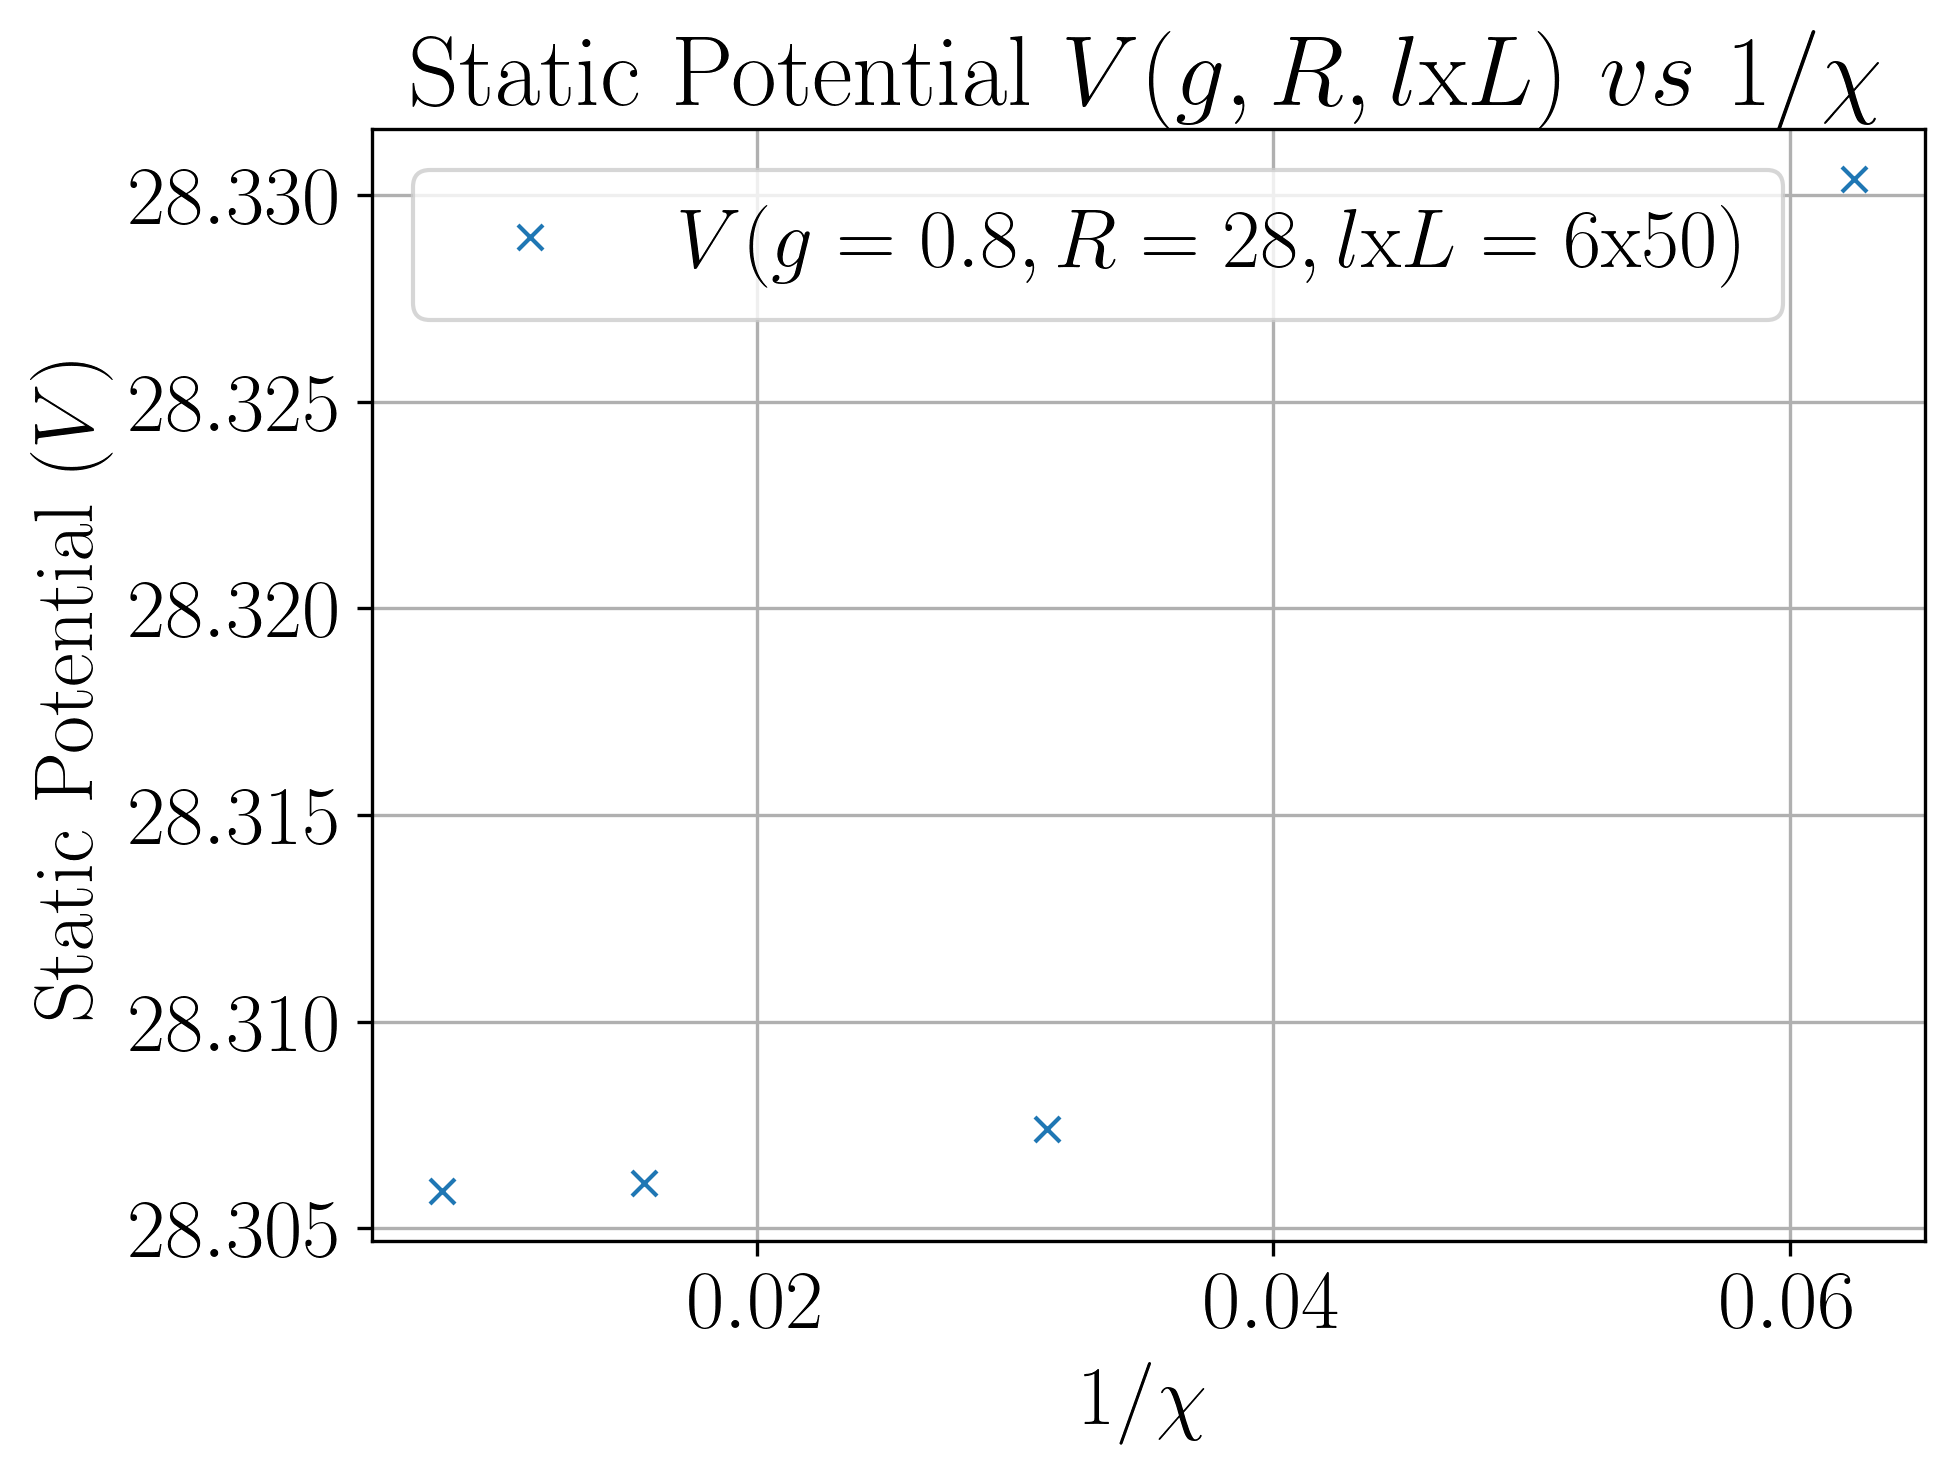

In [377]:
plt.plot([1/chi for chi in chis], potentials, 'x', label=f"$V(g={round(g,2)}, R={R}, l$x$L={l}$x${L})$")

plt.xlabel("$1/\chi$")
plt.ylabel("Static Potential $(V)$")
plt.title("Static Potential $V(g,R,l$x$L)$ $vs$ $1/\chi$")
plt.legend()
plt.grid(True)


### Asymptotic fit

Fitted exp potential in function of chi:


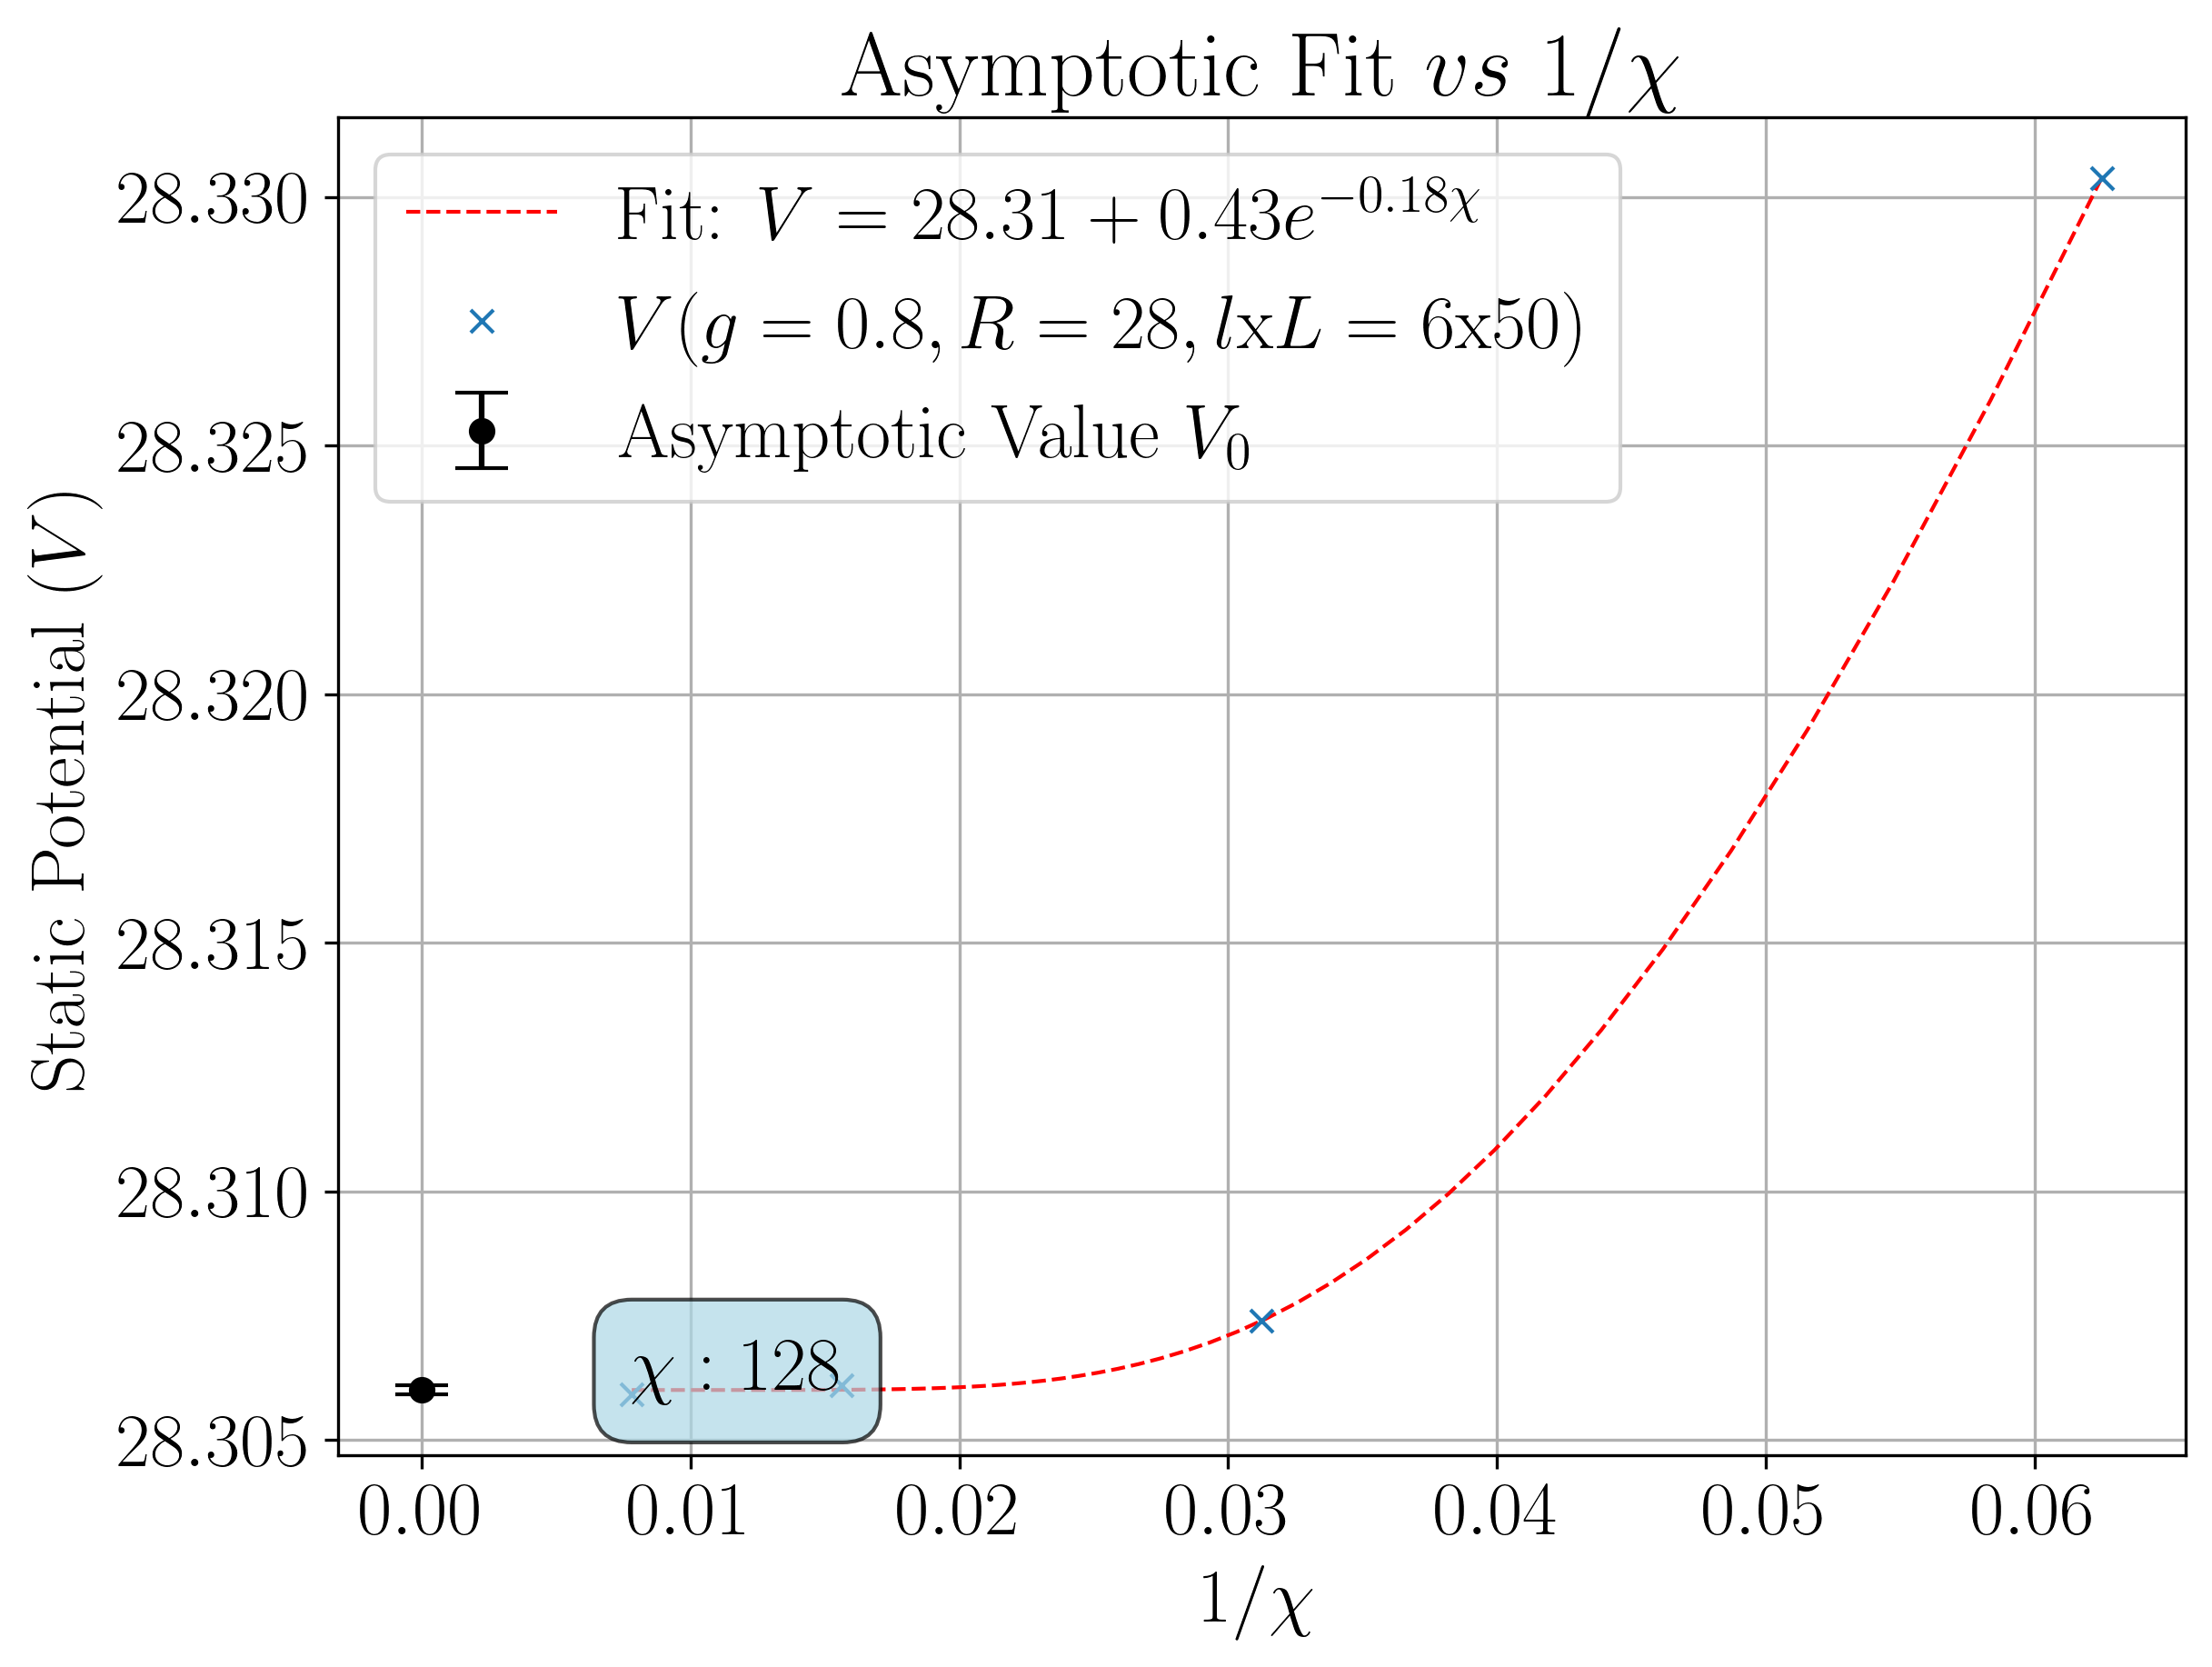

In [394]:
popt, errs = asymptotic_fit(potentials, chis, 'chi', fit_func="exp")
plot_asymptotic_fit(potentials, chis, 'chi', popt, errs, fit_func="exp")

We have found that, taking small and large bond dimensions $\chi$, the best fit is the exponential one.
Now we can iterate for different values of $g$ and $R$ to move to the next step, that is, taking care of finite size lattice effects.

# Study of the potential $V(g,R,L)$

Now we fix $g$ and $R$ and, by taking the values of V obtained for infinite $\chi$ we determine the finite size effect of our lattice in the $L$ direction.

In [363]:
Ls = [30,40,50]
g = 0.8
R = 22
potentials, err_L = static_potential_Ls(g,R,l,Ls,chis)

y0 (asymptotic value) = 22.314670 ± 0.000045
y0 (asymptotic value) = 22.314670 ± 0.000049
y0 (asymptotic value) = 22.314665 ± 0.000044


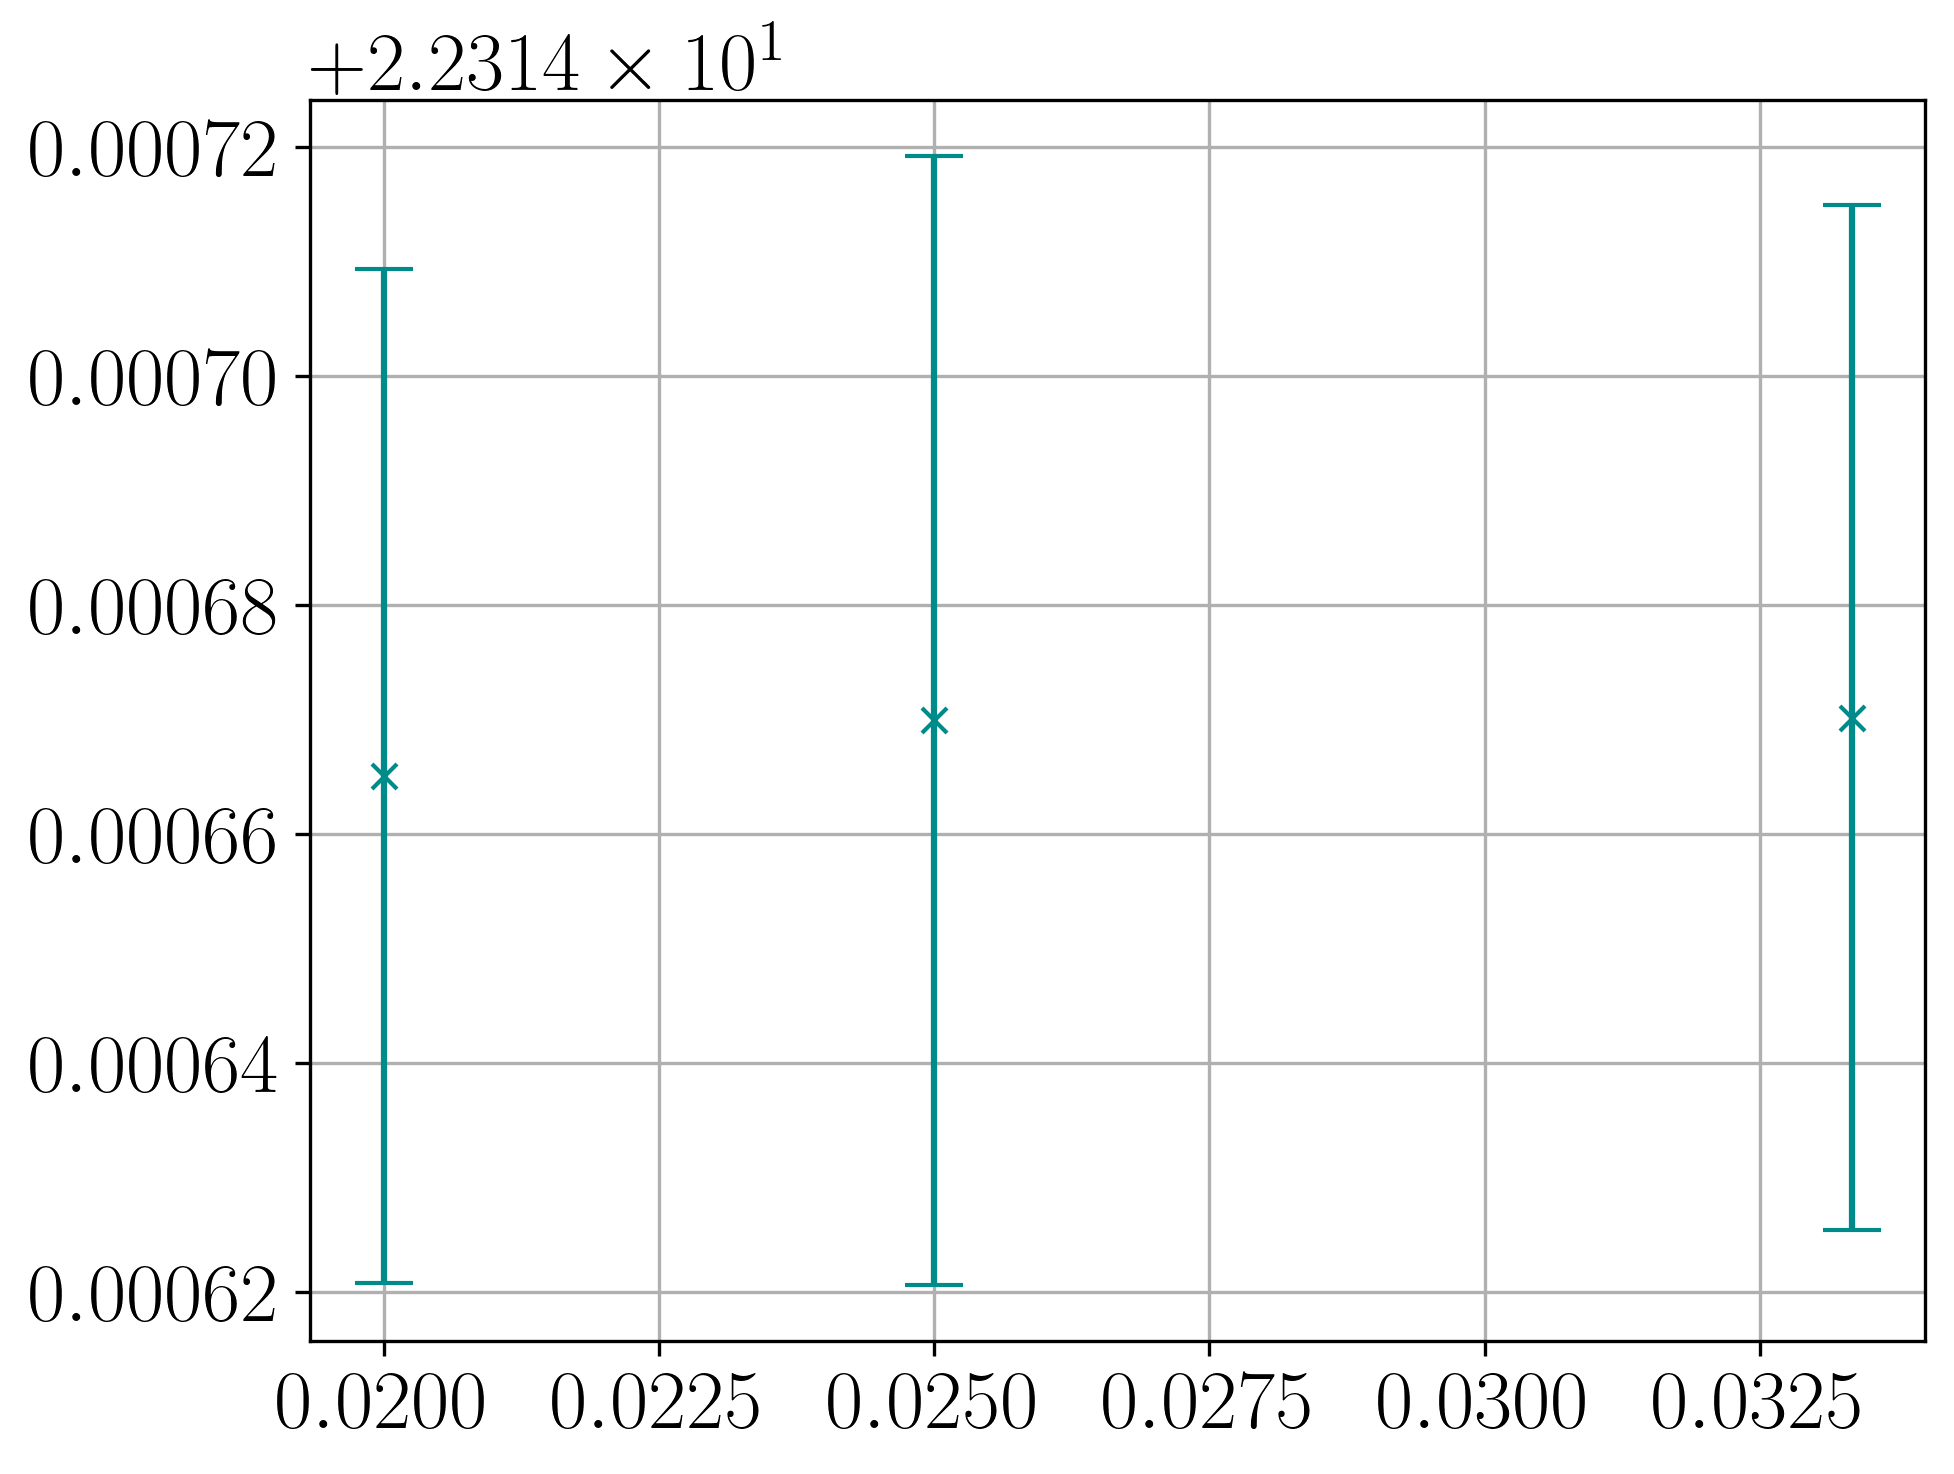

In [364]:
plt.errorbar([1/L for L in Ls], potentials, yerr=err_L, fmt='x', color='darkcyan', capsize=7)
plt.grid(True)
plt.show()

Next steps:
- make a fit (probably linear) taking into account the errors of the V found for exact bond dimension
- get the value for infinite $L$
- now we can find the potential with limited error due to mps approx and finite lattice, for different values of $g$ and $R$
- use these values of the potential to make derivative or fits to find the luscher term and the string tension

### Asymptotic fit

Fitted lin potential in function of L:


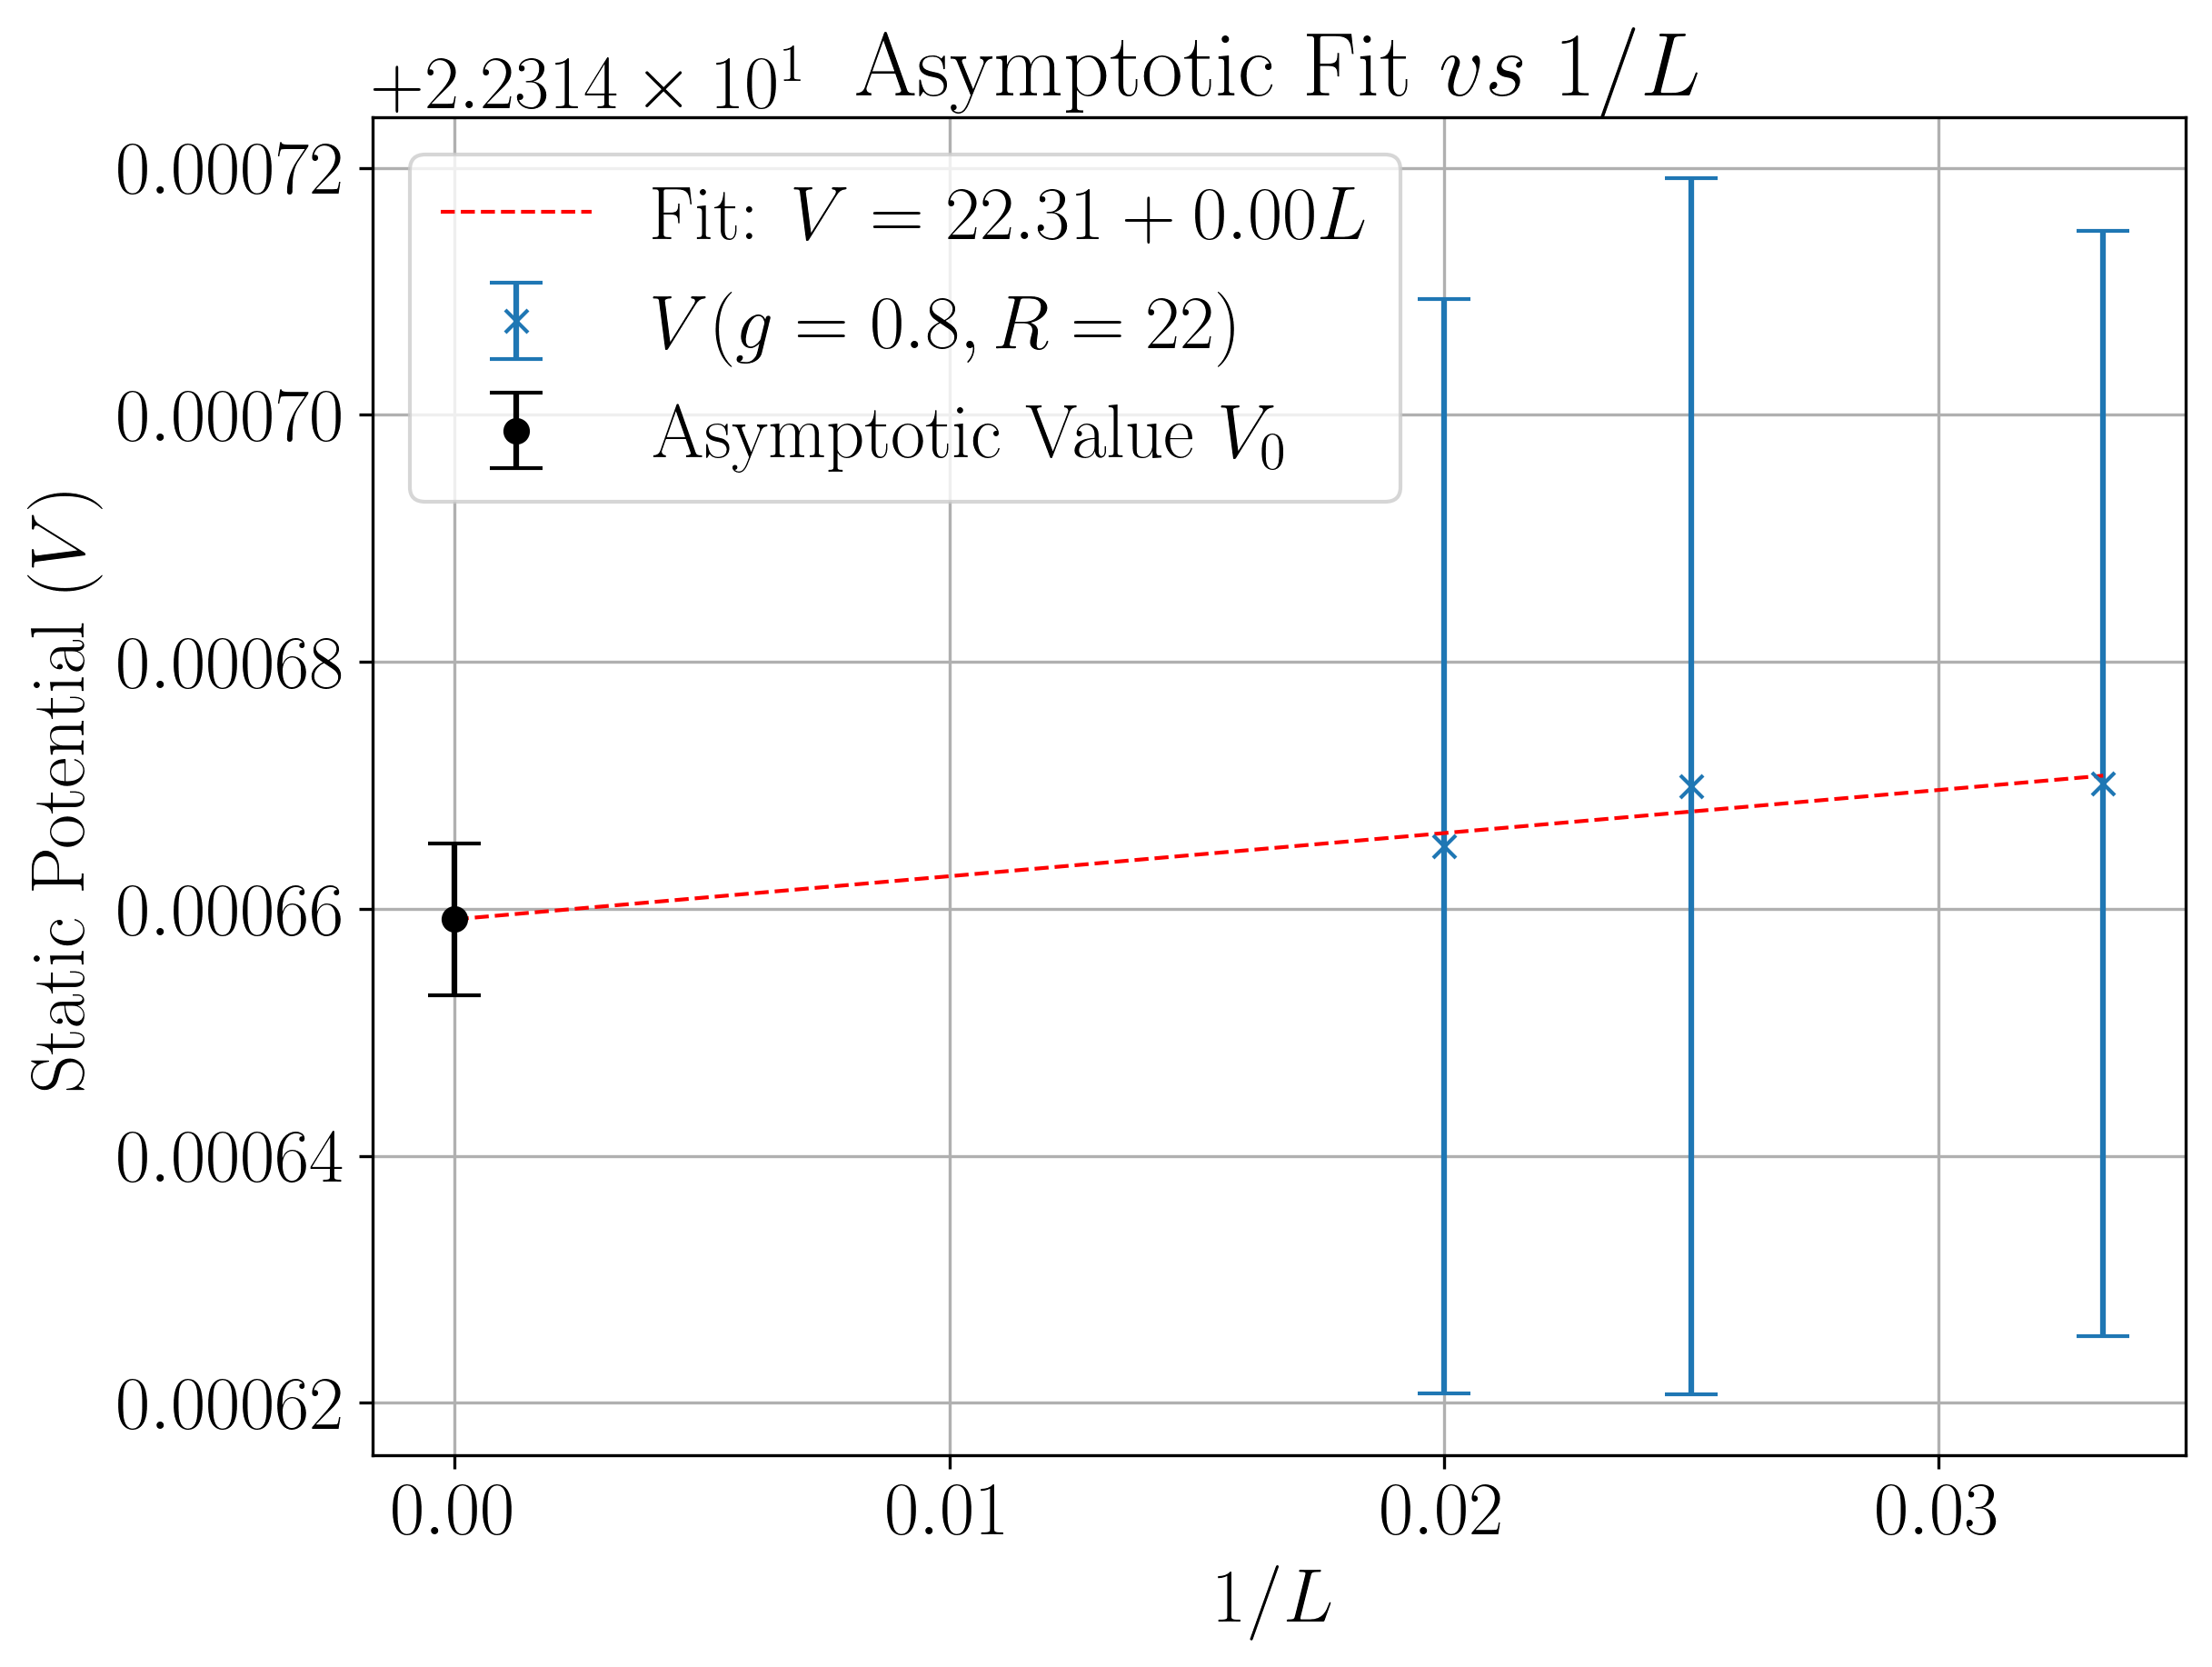

In [365]:
popt, errs = asymptotic_fit(potentials, Ls, 'L', y_err=err_L, fit_func="lin")
plot_asymptotic_fit(potentials, Ls, 'L', popt, errs, y_err=err_L, fit_func="lin")

## Getting the Luscher term with derivative

In [100]:
def discrete_derivative(gs,R,l,L,chis,a=2):
    potentials, err = static_potential_varying_g(gs,R,l,L,chis)
    potentials_p, err_p = static_potential_varying_g(gs,R+a,l,L,chis)
    potentials_m, err_m = static_potential_varying_g(gs,R-a,l,L,chis)
    luscher = luscher_term(potentials, potentials_p, potentials_m, R, a)
    luscher_err = 1/2 * (R**3) * np.sqrt(np.asarray(err_p)**2 + np.asarray(err_m)**2 + 4 * np.asarray(err)**2) / (a**2)
    return luscher, luscher_err

def luscher_term(pot, pot_p, pot_m, R, a):
    return 1/2 * (R**3) * (np.array(pot_p) + np.array(pot_m) - 2 * np.array(pot)) / (a**2)

In [101]:
luscher, err = discrete_derivative(gs,22,l,L,chis)

g: 0.8
y0 (asymptotic value) = 22.314670 ± 0.000045
g: 0.806896551724138
y0 (asymptotic value) = 22.926430 ± 0.000047
g: 0.8137931034482759
y0 (asymptotic value) = 23.532939 ± 0.000046
g: 0.8206896551724139
y0 (asymptotic value) = 24.134141 ± 0.000049
g: 0.8275862068965517
y0 (asymptotic value) = 24.729972 ± 0.000045
g: 0.8344827586206897
y0 (asymptotic value) = 25.320388 ± 0.000038
g: 0.8413793103448276
y0 (asymptotic value) = 25.905357 ± 0.000040
g: 0.8482758620689655
y0 (asymptotic value) = 26.484826 ± 0.000039
g: 0.8551724137931035
y0 (asymptotic value) = 27.058763 ± 0.000039
g: 0.8620689655172414
y0 (asymptotic value) = 27.627132 ± 0.000040
g: 0.8689655172413794
y0 (asymptotic value) = 28.189887 ± 0.000033
g: 0.8758620689655172
y0 (asymptotic value) = 28.747009 ± 0.000033
g: 0.8827586206896552
y0 (asymptotic value) = 29.298448 ± 0.000028
g: 0.8896551724137931
y0 (asymptotic value) = 29.844183 ± 0.000030
g: 0.896551724137931
y0 (asymptotic value) = 30.384169 ± 0.000029
g: 0.9034482

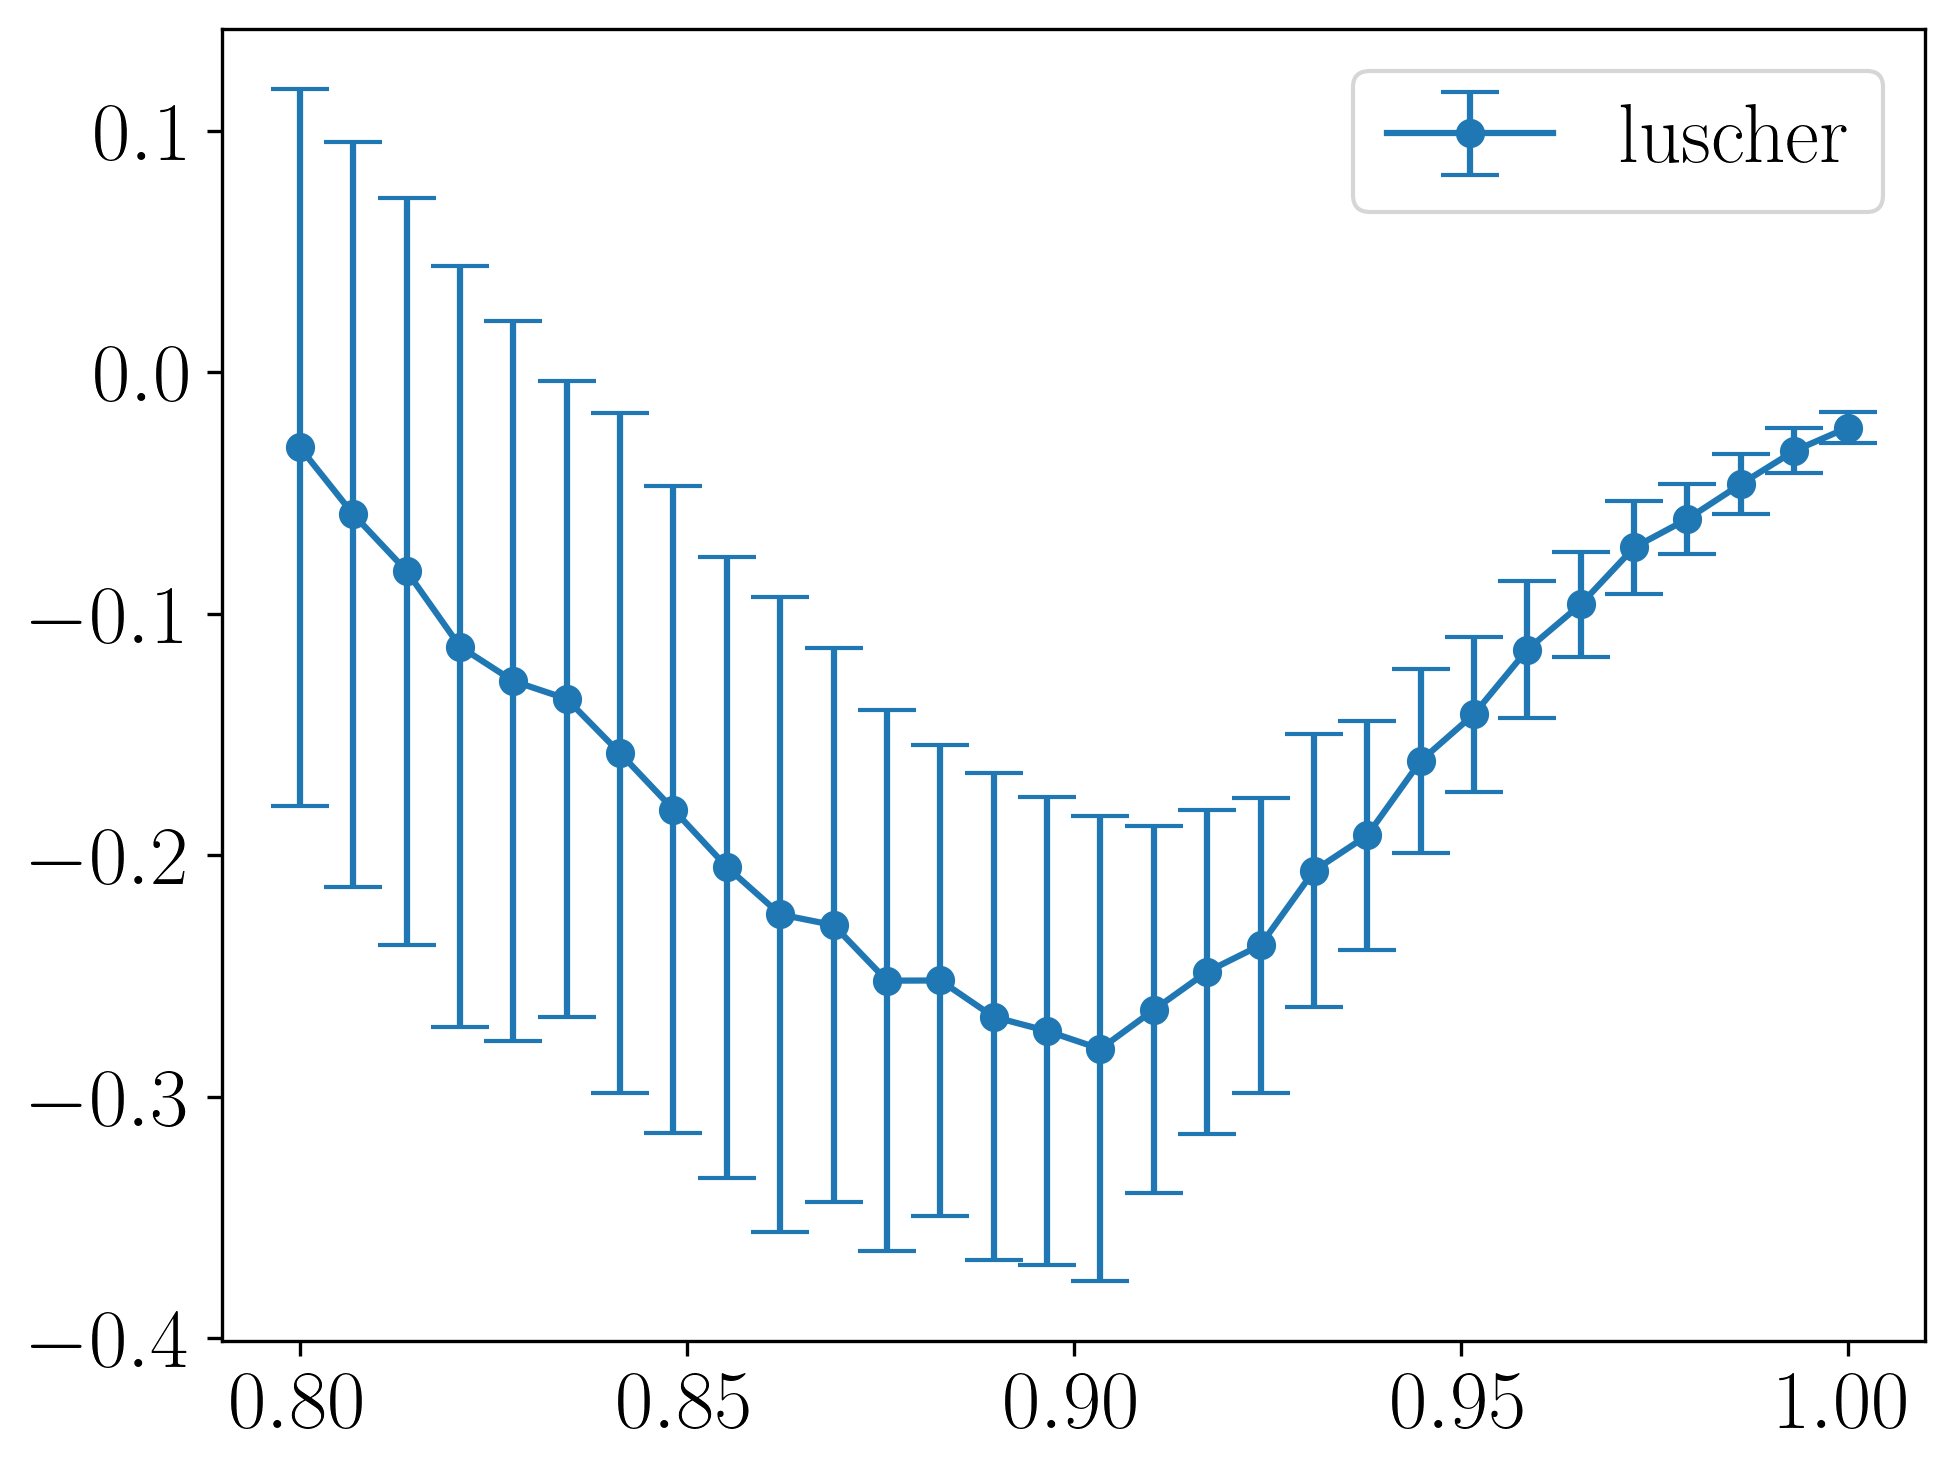

In [102]:
plt.errorbar(gs, luscher, yerr=err, capsize=7, marker='o', label="luscher")
plt.legend()

g: 0.8
y0 (asymptotic value) = 22.314670 ± 0.000045
g: 0.806896551724138
y0 (asymptotic value) = 22.926430 ± 0.000047
g: 0.8137931034482759
y0 (asymptotic value) = 23.532939 ± 0.000046
g: 0.8206896551724139
y0 (asymptotic value) = 24.134141 ± 0.000049
g: 0.8275862068965517
y0 (asymptotic value) = 24.729972 ± 0.000045
g: 0.8344827586206897
y0 (asymptotic value) = 25.320388 ± 0.000038
g: 0.8413793103448276
y0 (asymptotic value) = 25.905357 ± 0.000040
g: 0.8482758620689655
y0 (asymptotic value) = 26.484826 ± 0.000039
g: 0.8551724137931035
y0 (asymptotic value) = 27.058763 ± 0.000039
g: 0.8620689655172414
y0 (asymptotic value) = 27.627132 ± 0.000040
g: 0.8689655172413794
y0 (asymptotic value) = 28.189887 ± 0.000033
g: 0.8758620689655172
y0 (asymptotic value) = 28.747009 ± 0.000033
g: 0.8827586206896552
y0 (asymptotic value) = 29.298448 ± 0.000028
g: 0.8896551724137931
y0 (asymptotic value) = 29.844183 ± 0.000030
g: 0.896551724137931
y0 (asymptotic value) = 30.384169 ± 0.000029
g: 0.9034482

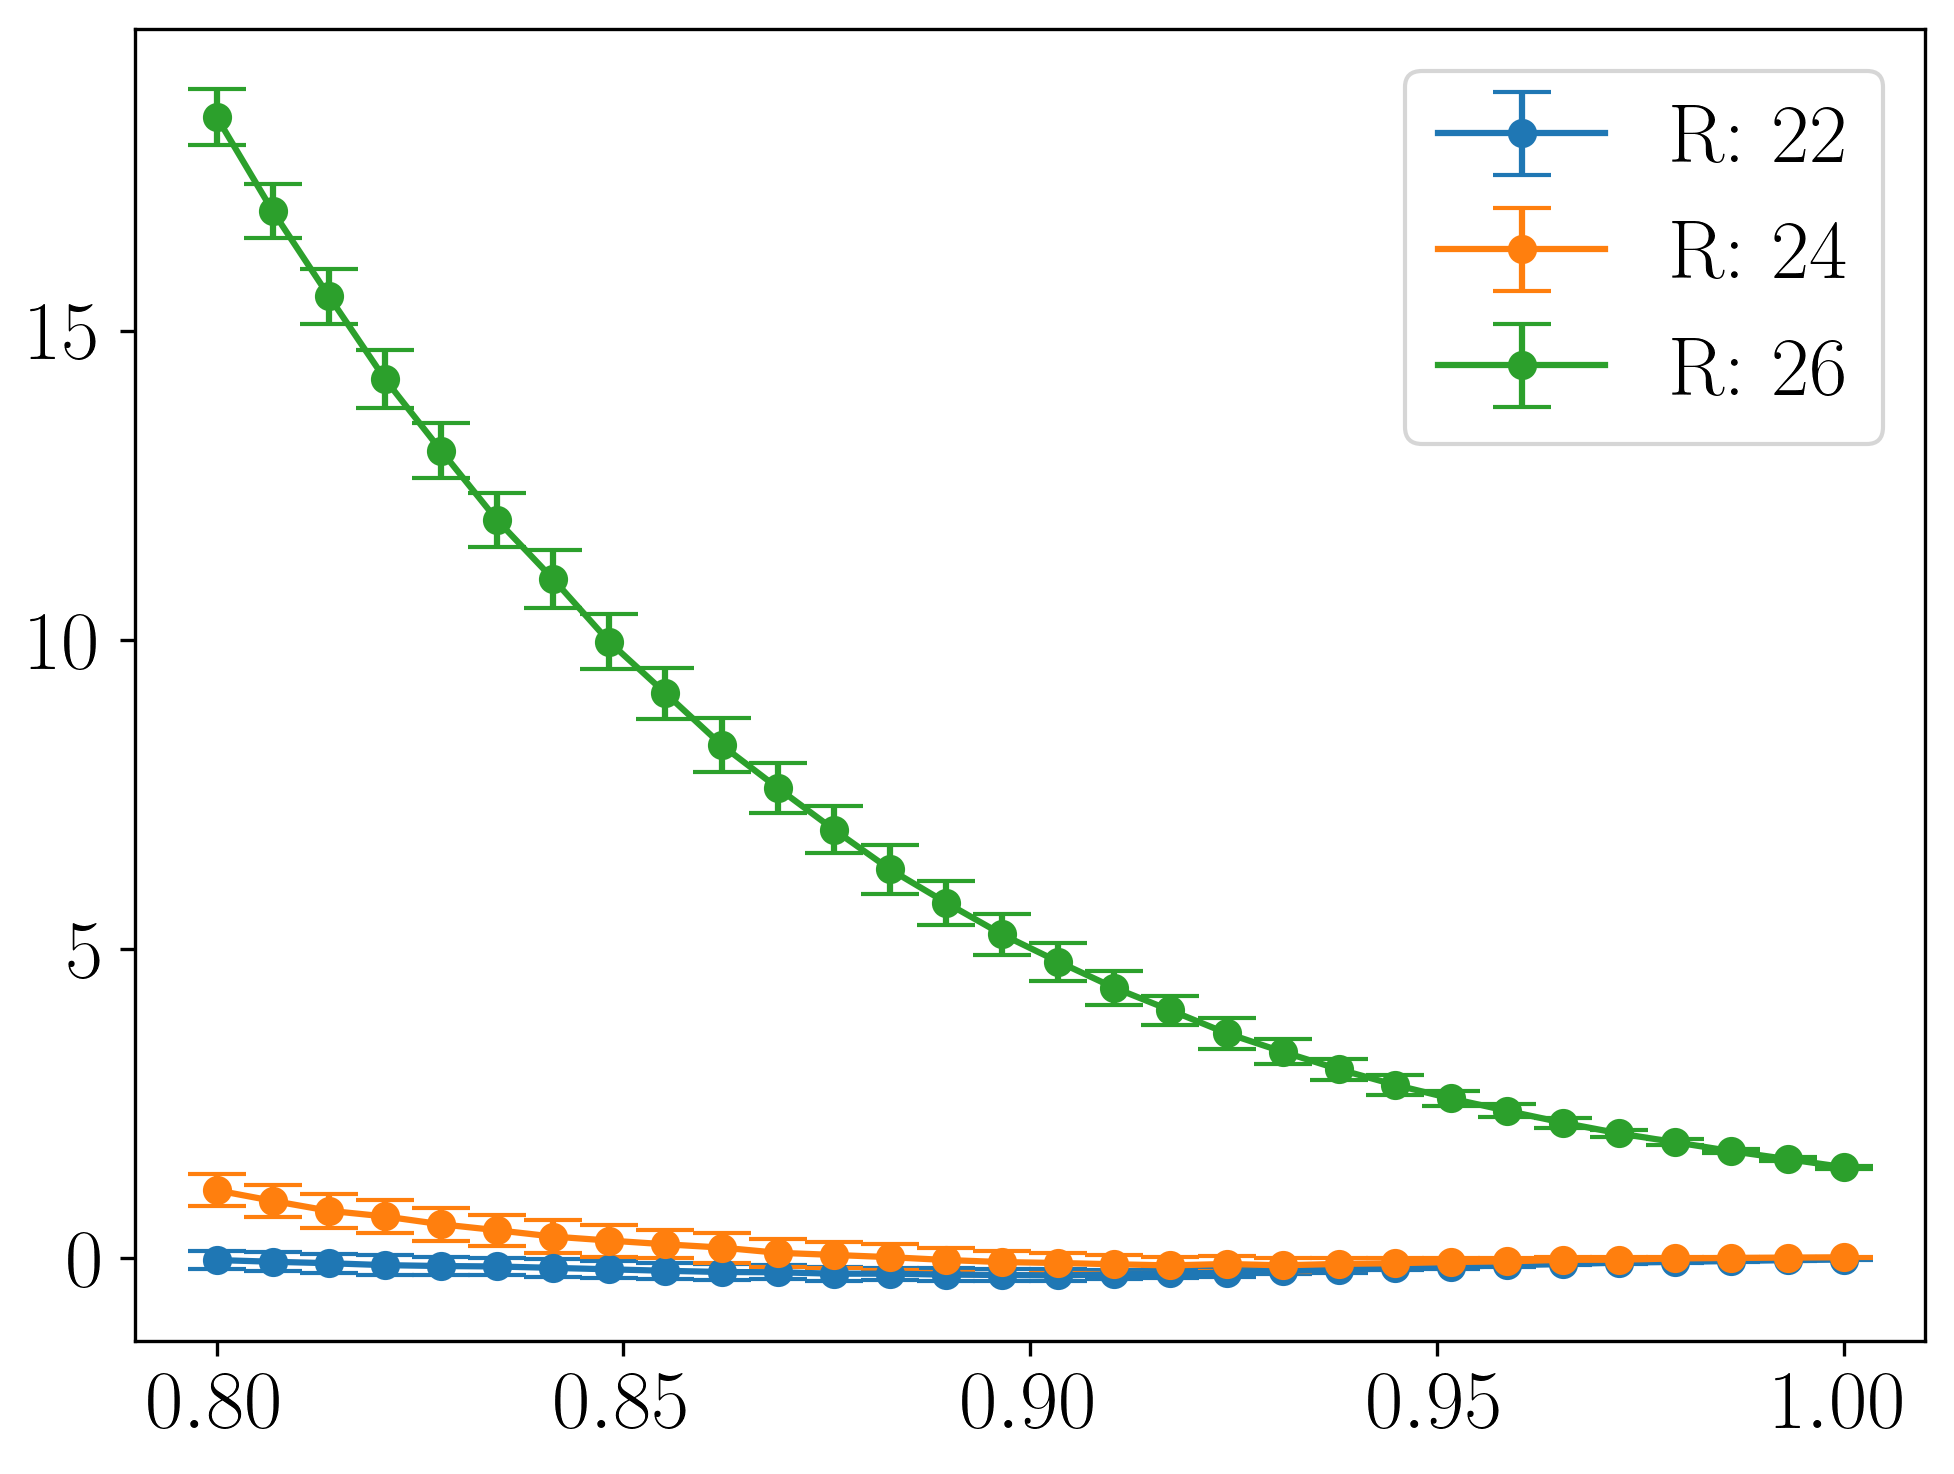

In [103]:
Rs = [22,24,26]
colors = create_sequential_colors(len(Rs))
for i, R in enumerate(Rs):
    luscher, err = discrete_derivative(gs,R,l,L,chis)
    plt.errorbar(gs, luscher, yerr=err, capsize=7, marker='o', label=f"R: {R}")

plt.legend()

## Getting the Luscher term with fit

In [277]:
def luscher_fit(R, sigma, mu, gamma):
    return sigma*R + mu + gamma/R

def fitting(Rs, potentials, errors):
    popt, pcov = curve_fit(luscher_fit, Rs, potentials, sigma=errors)
    errs = np.sqrt(np.diag(pcov))
    return popt, errs

def fit_luscher_term_g(g, Rs, l, L, chis):
    pot, err = static_potential_varying_R(g, Rs, l, L, chis)
    popt, errs = fitting(Rs, pot, err)
    term = popt[2]
    term_err = errs[2]
    return term, term_err

def fit_luscher(gs, Rs, l, L, chis):
    luschers = []
    luscher_errs = []
    for g in gs:
        luscher, luscher_err = fit_luscher_term_g(g, Rs, l, L, chis)
        luschers.append(luscher)
        luscher_errs.append(luscher_err)
    return luschers, luscher_errs

In [278]:
L = 50
Rs = [20,22,24,26,28]
gammas, gammas_err = fit_luscher(gs, Rs, l, L, chis)

R: 20
y0 (asymptotic value) = 20.317438 ± 0.000033
R: 22
y0 (asymptotic value) = 22.314665 ± 0.000044
R: 24
y0 (asymptotic value) = 24.311821 ± 0.000062
R: 26
y0 (asymptotic value) = 26.308932 ± 0.000082
R: 28
y0 (asymptotic value) = 28.306004 ± 0.000094
R: 20
y0 (asymptotic value) = 20.873090 ± 0.000006
R: 22
y0 (asymptotic value) = 22.926382 ± 0.000007
R: 24
y0 (asymptotic value) = 24.979591 ± 0.000005
R: 26
y0 (asymptotic value) = 27.032742 ± 0.000006
R: 28
y0 (asymptotic value) = 29.085858 ± 0.000005
R: 20
y0 (asymptotic value) = 21.423956 ± 0.000004
R: 22
y0 (asymptotic value) = 23.532890 ± 0.000004
R: 24
y0 (asymptotic value) = 25.641729 ± 0.000002
R: 26
y0 (asymptotic value) = 27.750504 ± 0.000002
R: 28
y0 (asymptotic value) = 29.859234 ± 0.000001
R: 20
y0 (asymptotic value) = 21.969955 ± 0.000004
R: 22
y0 (asymptotic value) = 24.134089 ± 0.000003
R: 24
y0 (asymptotic value) = 26.298118 ± 0.000001
R: 26
y0 (asymptotic value) = 28.462072 ± 0.000001
R: 28
y0 (asymptotic value) = 3

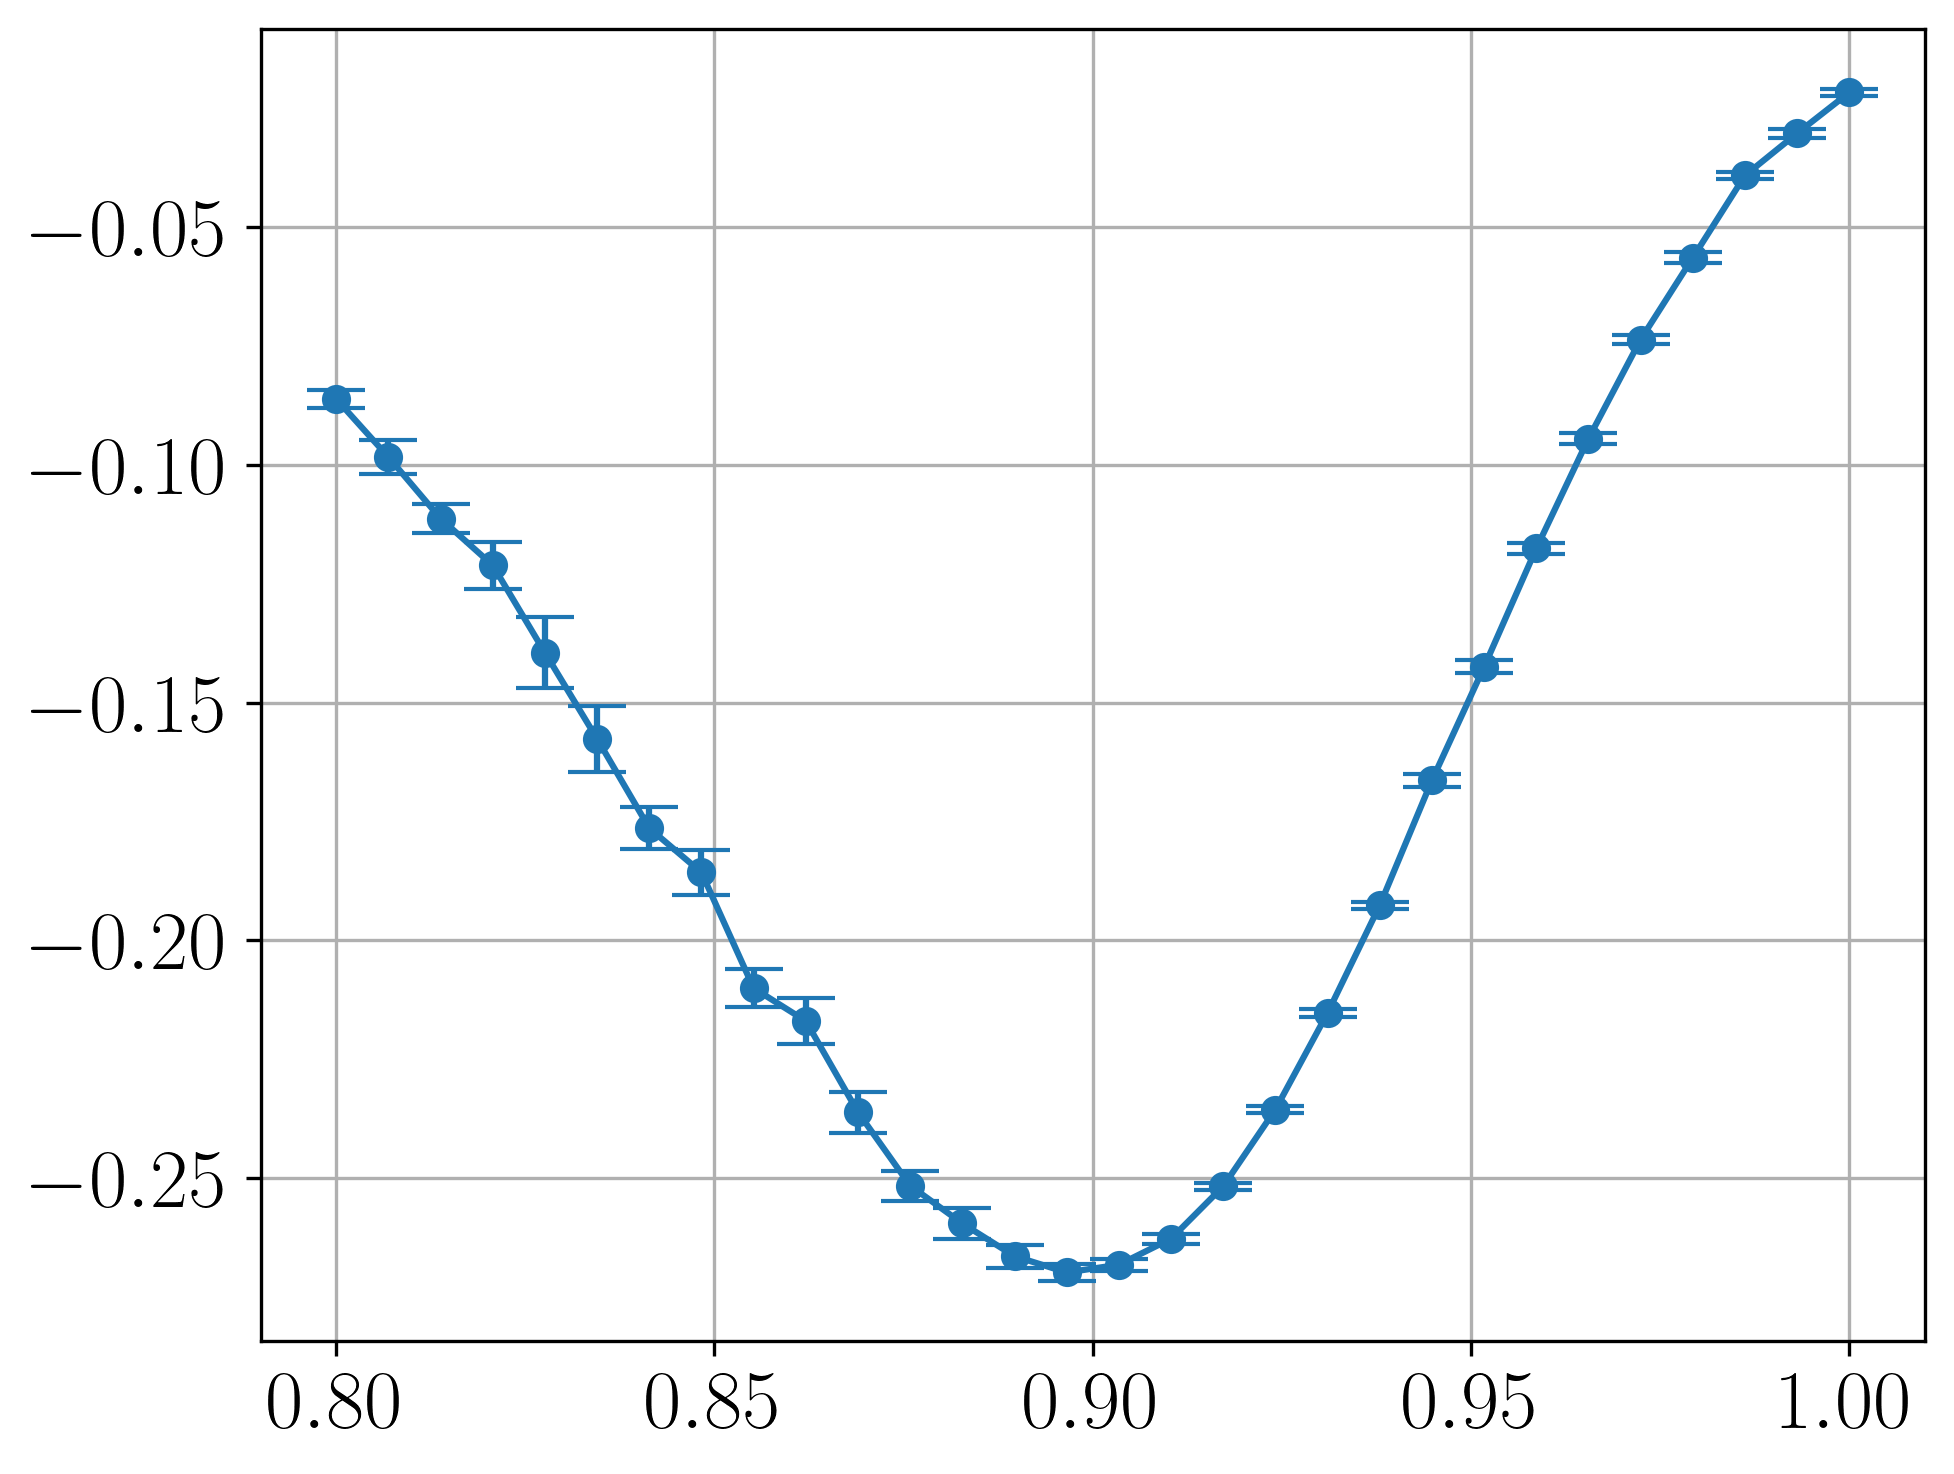

In [280]:
plt.errorbar(gs, gammas, yerr=gammas_err, capsize=7, marker='o')
plt.grid(True)

In [281]:
round(-np.pi/12,5), round(min(gammas) + gammas_err[np.argmin(gammas)], 5), round(min(gammas) - gammas_err[np.argmin(gammas)], 5)

(-0.2618, -0.268, -0.27175)

### Luscher Term: $OBC$ $vs$ $PBC$

R: 20
y0 (asymptotic value) = 20.317438 ± 0.000033
R: 22
y0 (asymptotic value) = 22.314665 ± 0.000044
R: 24
y0 (asymptotic value) = 24.311821 ± 0.000062
R: 26
y0 (asymptotic value) = 26.308932 ± 0.000082
R: 28
y0 (asymptotic value) = 28.306004 ± 0.000094
R: 20
y0 (asymptotic value) = 20.873090 ± 0.000006
R: 22
y0 (asymptotic value) = 22.926382 ± 0.000007
R: 24
y0 (asymptotic value) = 24.979591 ± 0.000005
R: 26
y0 (asymptotic value) = 27.032742 ± 0.000006
R: 28
y0 (asymptotic value) = 29.085858 ± 0.000005
R: 20
y0 (asymptotic value) = 21.423956 ± 0.000004
R: 22
y0 (asymptotic value) = 23.532890 ± 0.000004
R: 24
y0 (asymptotic value) = 25.641729 ± 0.000002
R: 26
y0 (asymptotic value) = 27.750504 ± 0.000002
R: 28
y0 (asymptotic value) = 29.859234 ± 0.000001
R: 20
y0 (asymptotic value) = 21.969955 ± 0.000004
R: 22
y0 (asymptotic value) = 24.134089 ± 0.000003
R: 24
y0 (asymptotic value) = 26.298118 ± 0.000001
R: 26
y0 (asymptotic value) = 28.462072 ± 0.000001
R: 28
y0 (asymptotic value) = 3

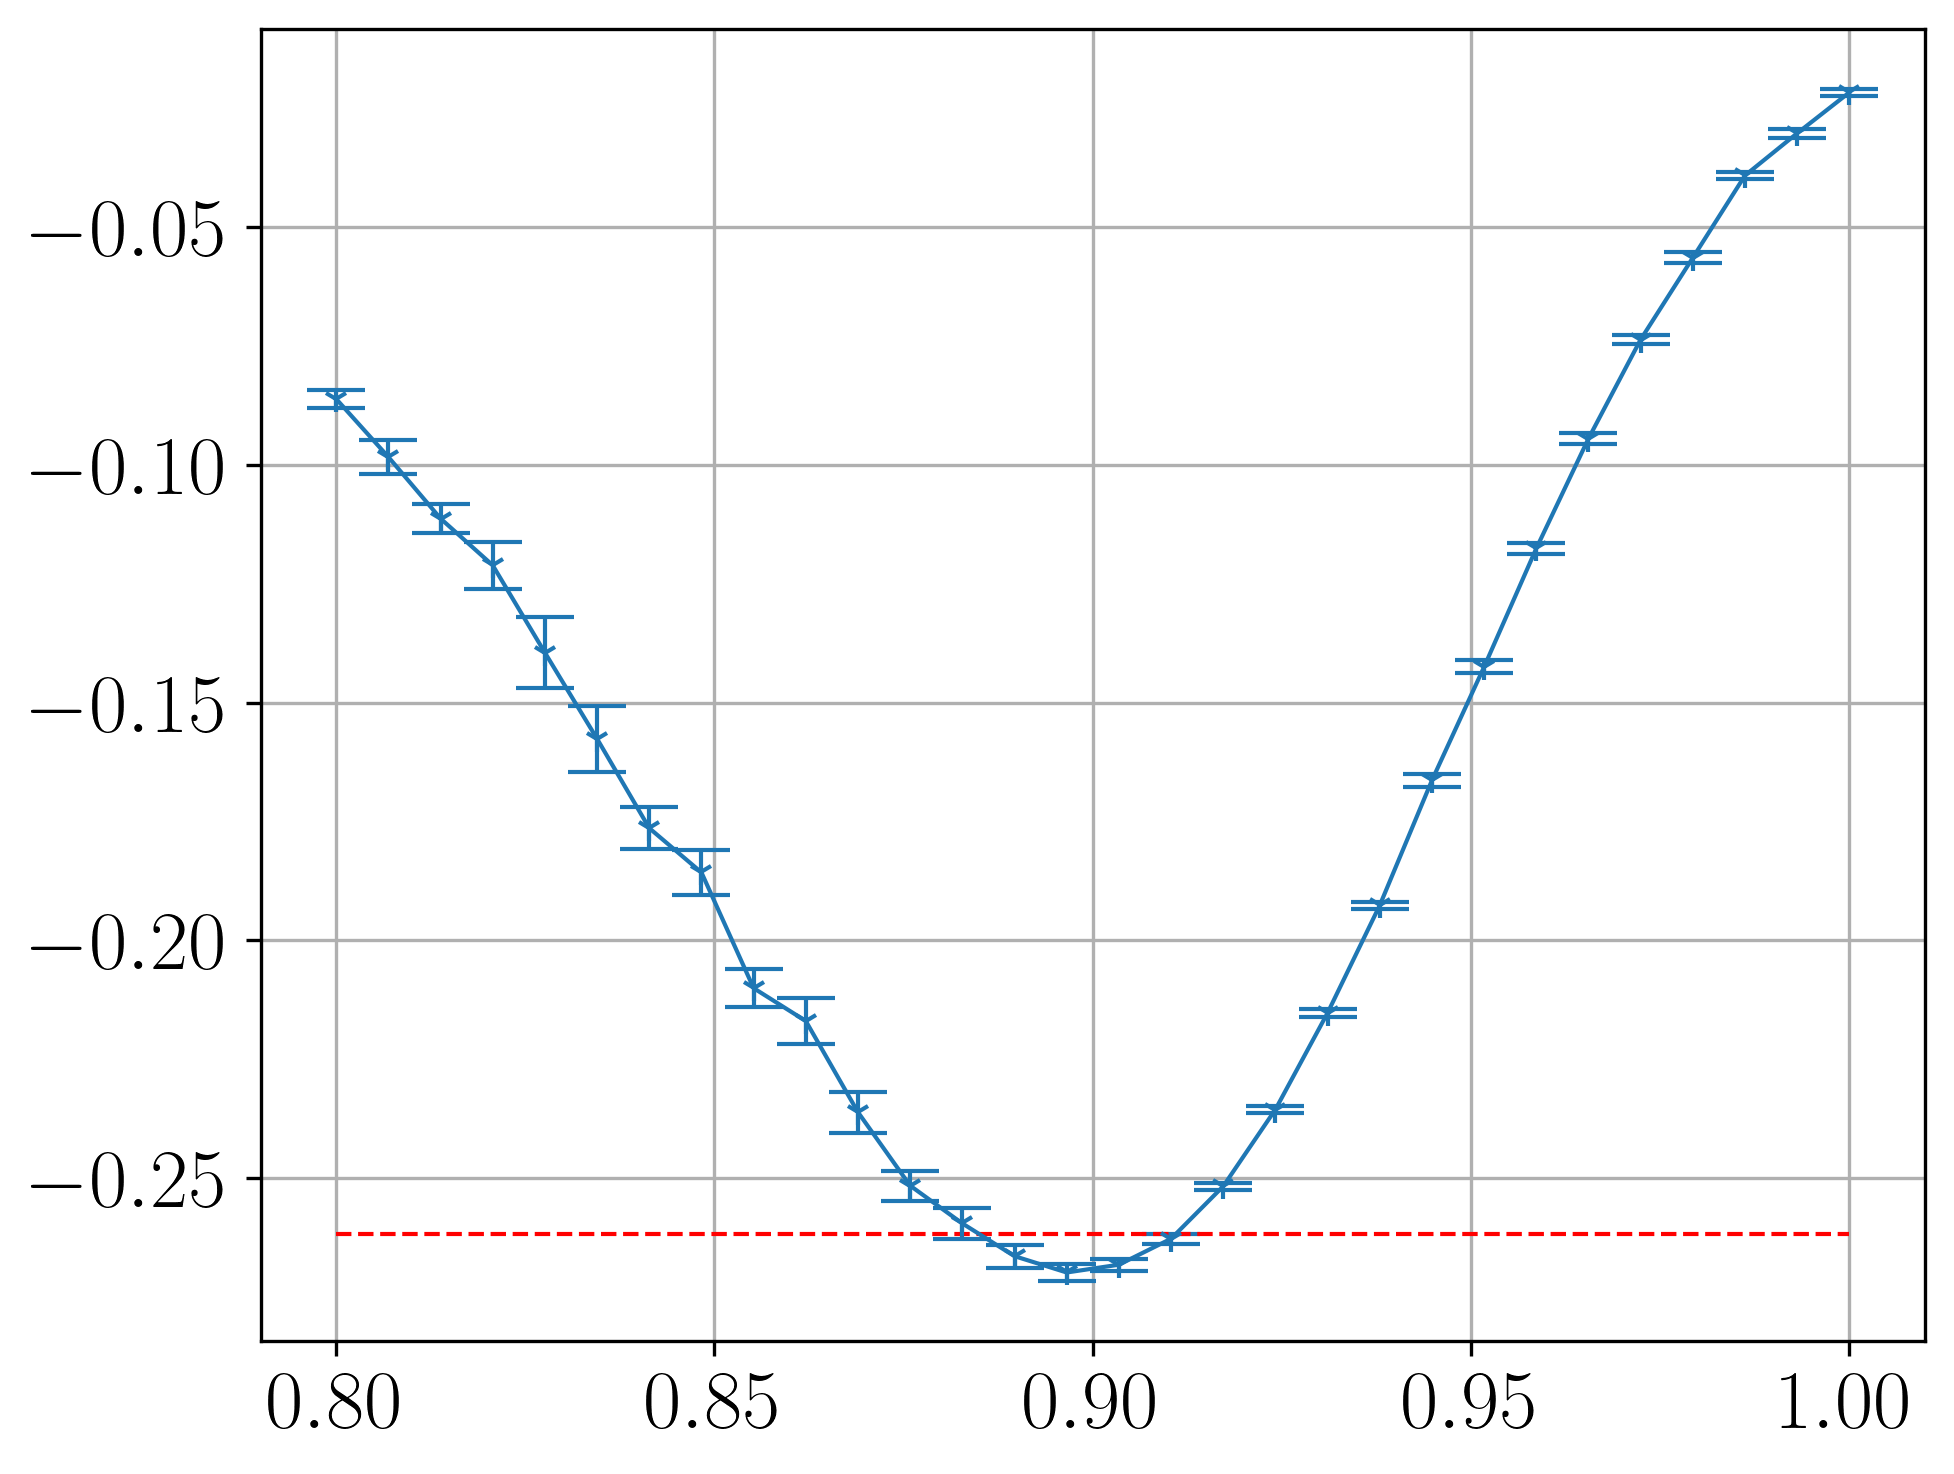

In [321]:
l, L = 6, 50
npoints, h_i, h_f = 30, 0.8, 1.0
interval = np.linspace(h_i,h_f,npoints)
gs = interval
boundcond = "obc"
chis = [16,32,64,128]
Rs = [20,22,24,26,28]
gammas, gammas_err = fit_luscher(gs, Rs, l, L, chis)
plt.errorbar(gs, gammas, yerr=gammas_err, capsize=7, marker='1', linewidth=1)
plt.hlines(y=-np.pi/12, xmin=gs[0], xmax=gs[-1], linestyles="--", colors='red', linewidth=1)
plt.grid(True)

[0.9984296614033311, 1.0264194721621607, 1.0542075034450211, 1.0817744045329043, 1.1090691508505488, 1.1362290598598708, 1.1631180341316742, 1.1896818377342562, 1.2161973770697716, 1.2423953936804784, 1.2683575654384496, 1.2940857160668588, 1.3195789873488077, 1.3448358766984942, 1.369854450535791, 1.3946321103267154, 1.4191655079381325, 1.4434503060598394, 1.4674612148210222, 1.4912338433450512, 1.5147418875449812, 1.537947476389202, 1.5609188227093382, 1.583591409381484, 1.60598226985852, 1.6280953835637435, 1.649912945185755, 1.67145242842508, 1.6927211485777134, 1.7137275021104625]


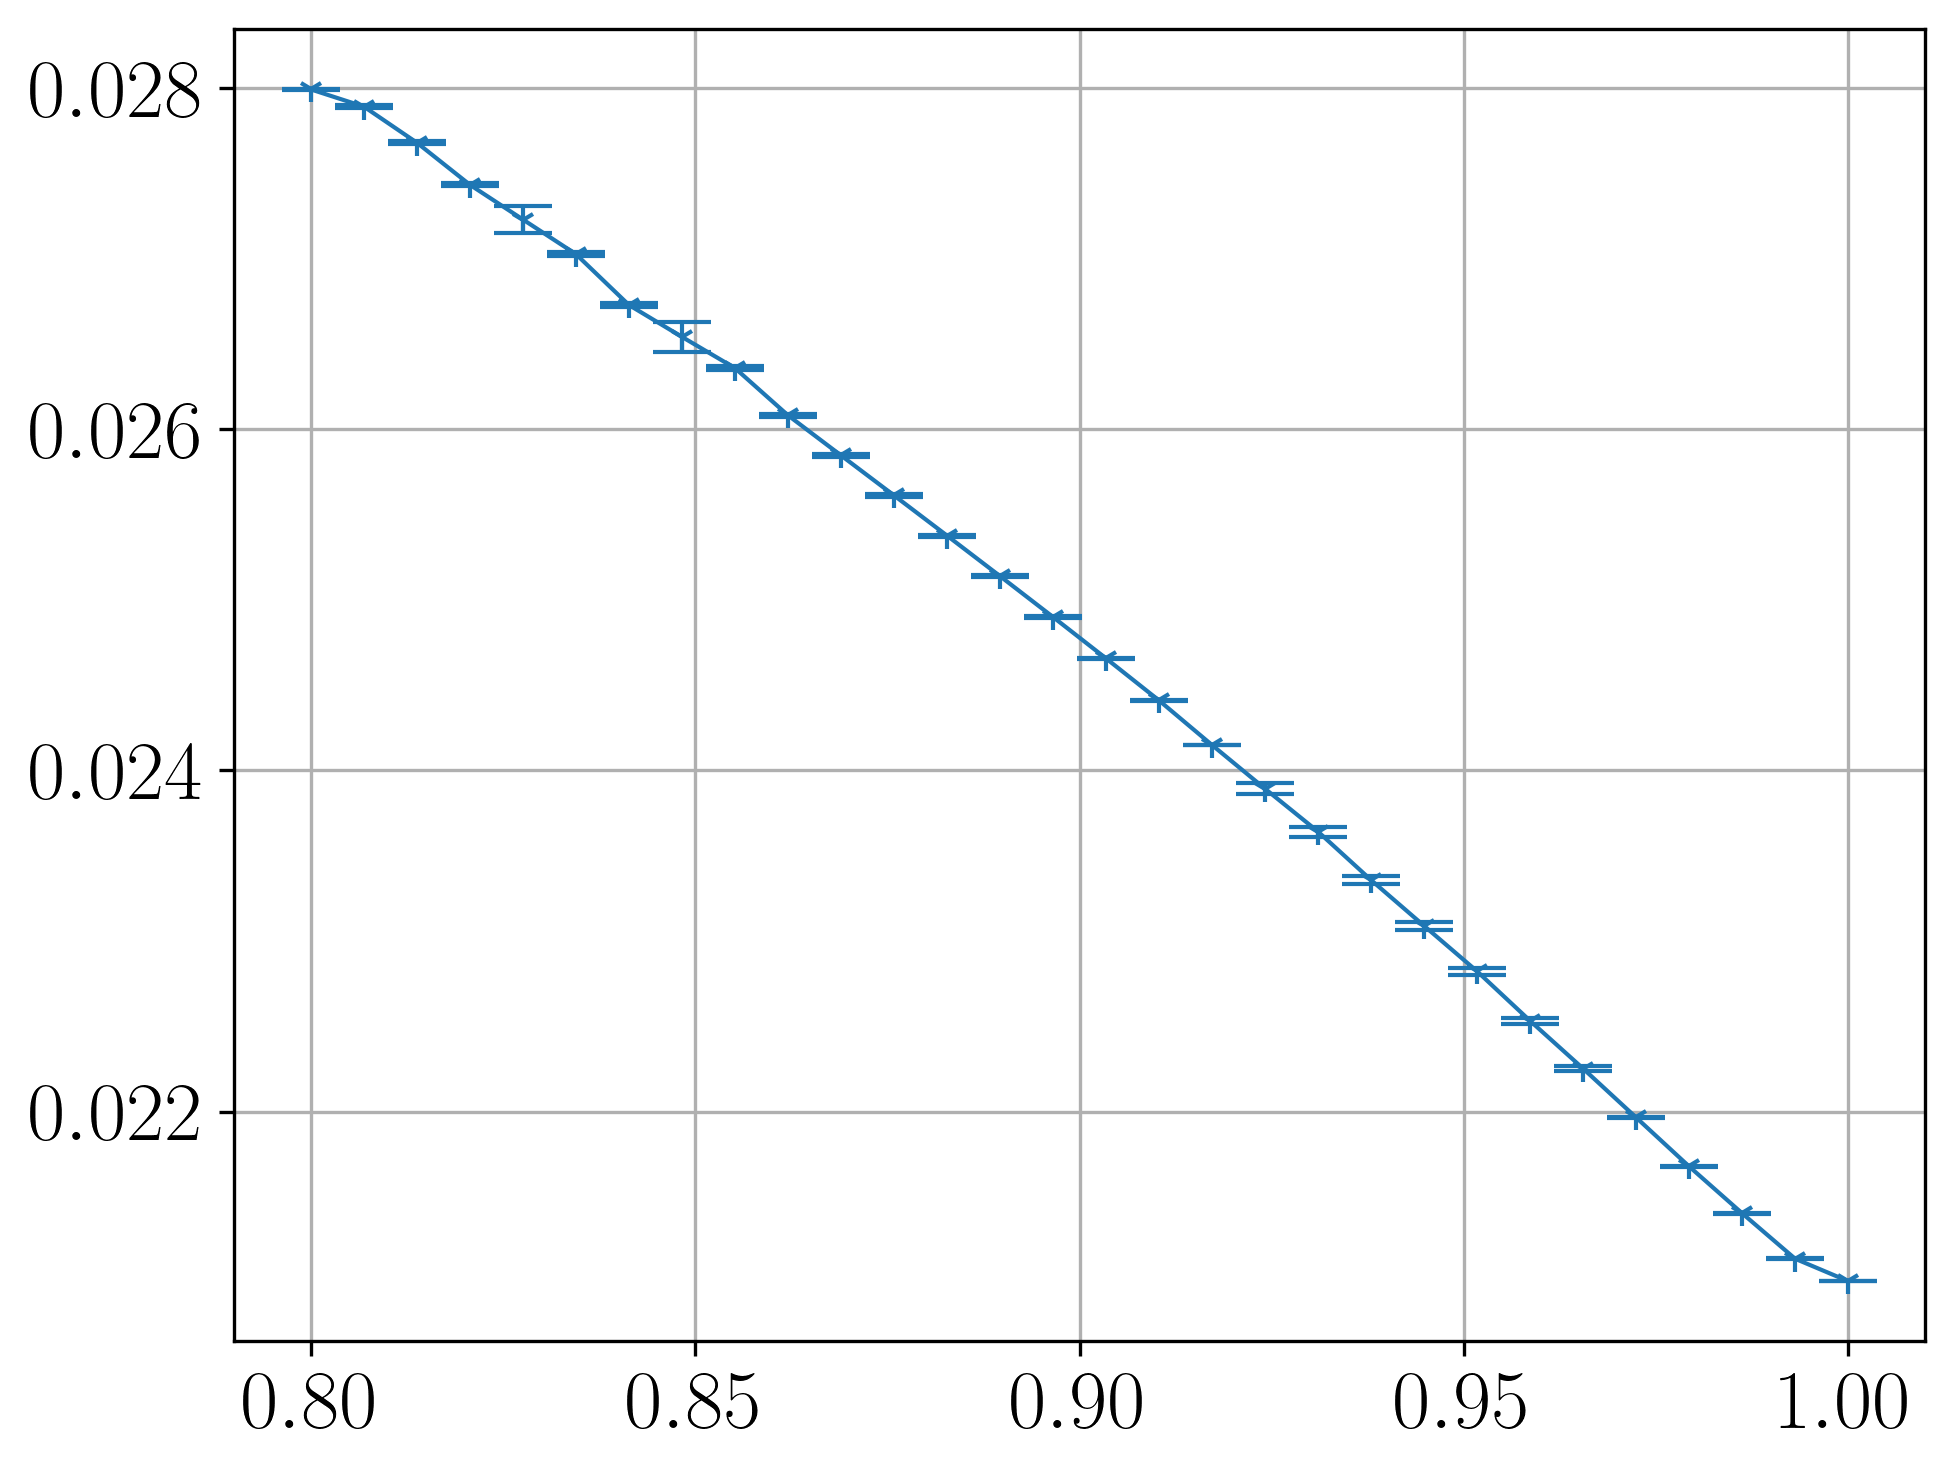

In [324]:
sigmas_pbc, sigmas_pbc_err = [], []
for g in gs:
    potentials = [static_potential(g,R,l,L,chi) for R in Rs]
    popt, pcov = curve_fit(luscher_fit, Rs, potentials)
    errs = np.sqrt(np.diag(pcov))
    sigmas_pbc.append(popt[0])
    sigmas_pbc_err.append(errs[0])
# sigmas_pbc, sigmas_pbc_err = fit_luscher(gs, Rs, l, L, chis)
plt.errorbar(gs, np.gradient(sigmas_pbc), yerr=sigmas_pbc_err, capsize=7, marker='1', linewidth=1)
# plt.errorbar(gs, sigmas_pbc, yerr=sigmas_pbc_err, capsize=7, marker='1', linewidth=1)
plt.grid(True)
print(sigmas_pbc)

[0.0024933840234297134, 0.004200494027301804, 0.007023537358667618, 0.011659564062934856, 0.0192197919127078, 0.03146426715627057, 0.051153746082823255, 0.08256480813207072, 0.13231954593886788, 0.21033042023098047, 0.3313796143671043, 0.5168180259277463, 0.7964724608322438, 1.2099588799543533, 1.805959255250427, 2.6367722878736575, 3.7441821482935516, 5.132642190663241, 6.730721736946675, 8.355190881459272, 9.71252953699964, 10.476847716806699, 10.434730436119175, 9.60395072807294, 8.222077556053803, 6.615400375174014, 5.059550587332696, 3.714318107446495, 2.6312164929501676, 1.7913518480812103, 1.1427705500439849, 0.6259927417305288, 0.1885624499050407, -0.20425482794178074, -0.5627362155796715, -0.8678954257275668, -1.078873943594068, -1.1581170426132896, -1.1040445315688363, -0.961379983792051, -0.793871515482076, -0.6481597337597912, -0.5417108615988295, -0.47215401658655054, -0.43018072437576904, -0.4064038628115056, -0.39341379177648306, -0.38561100917855584, -0.3786947792355591

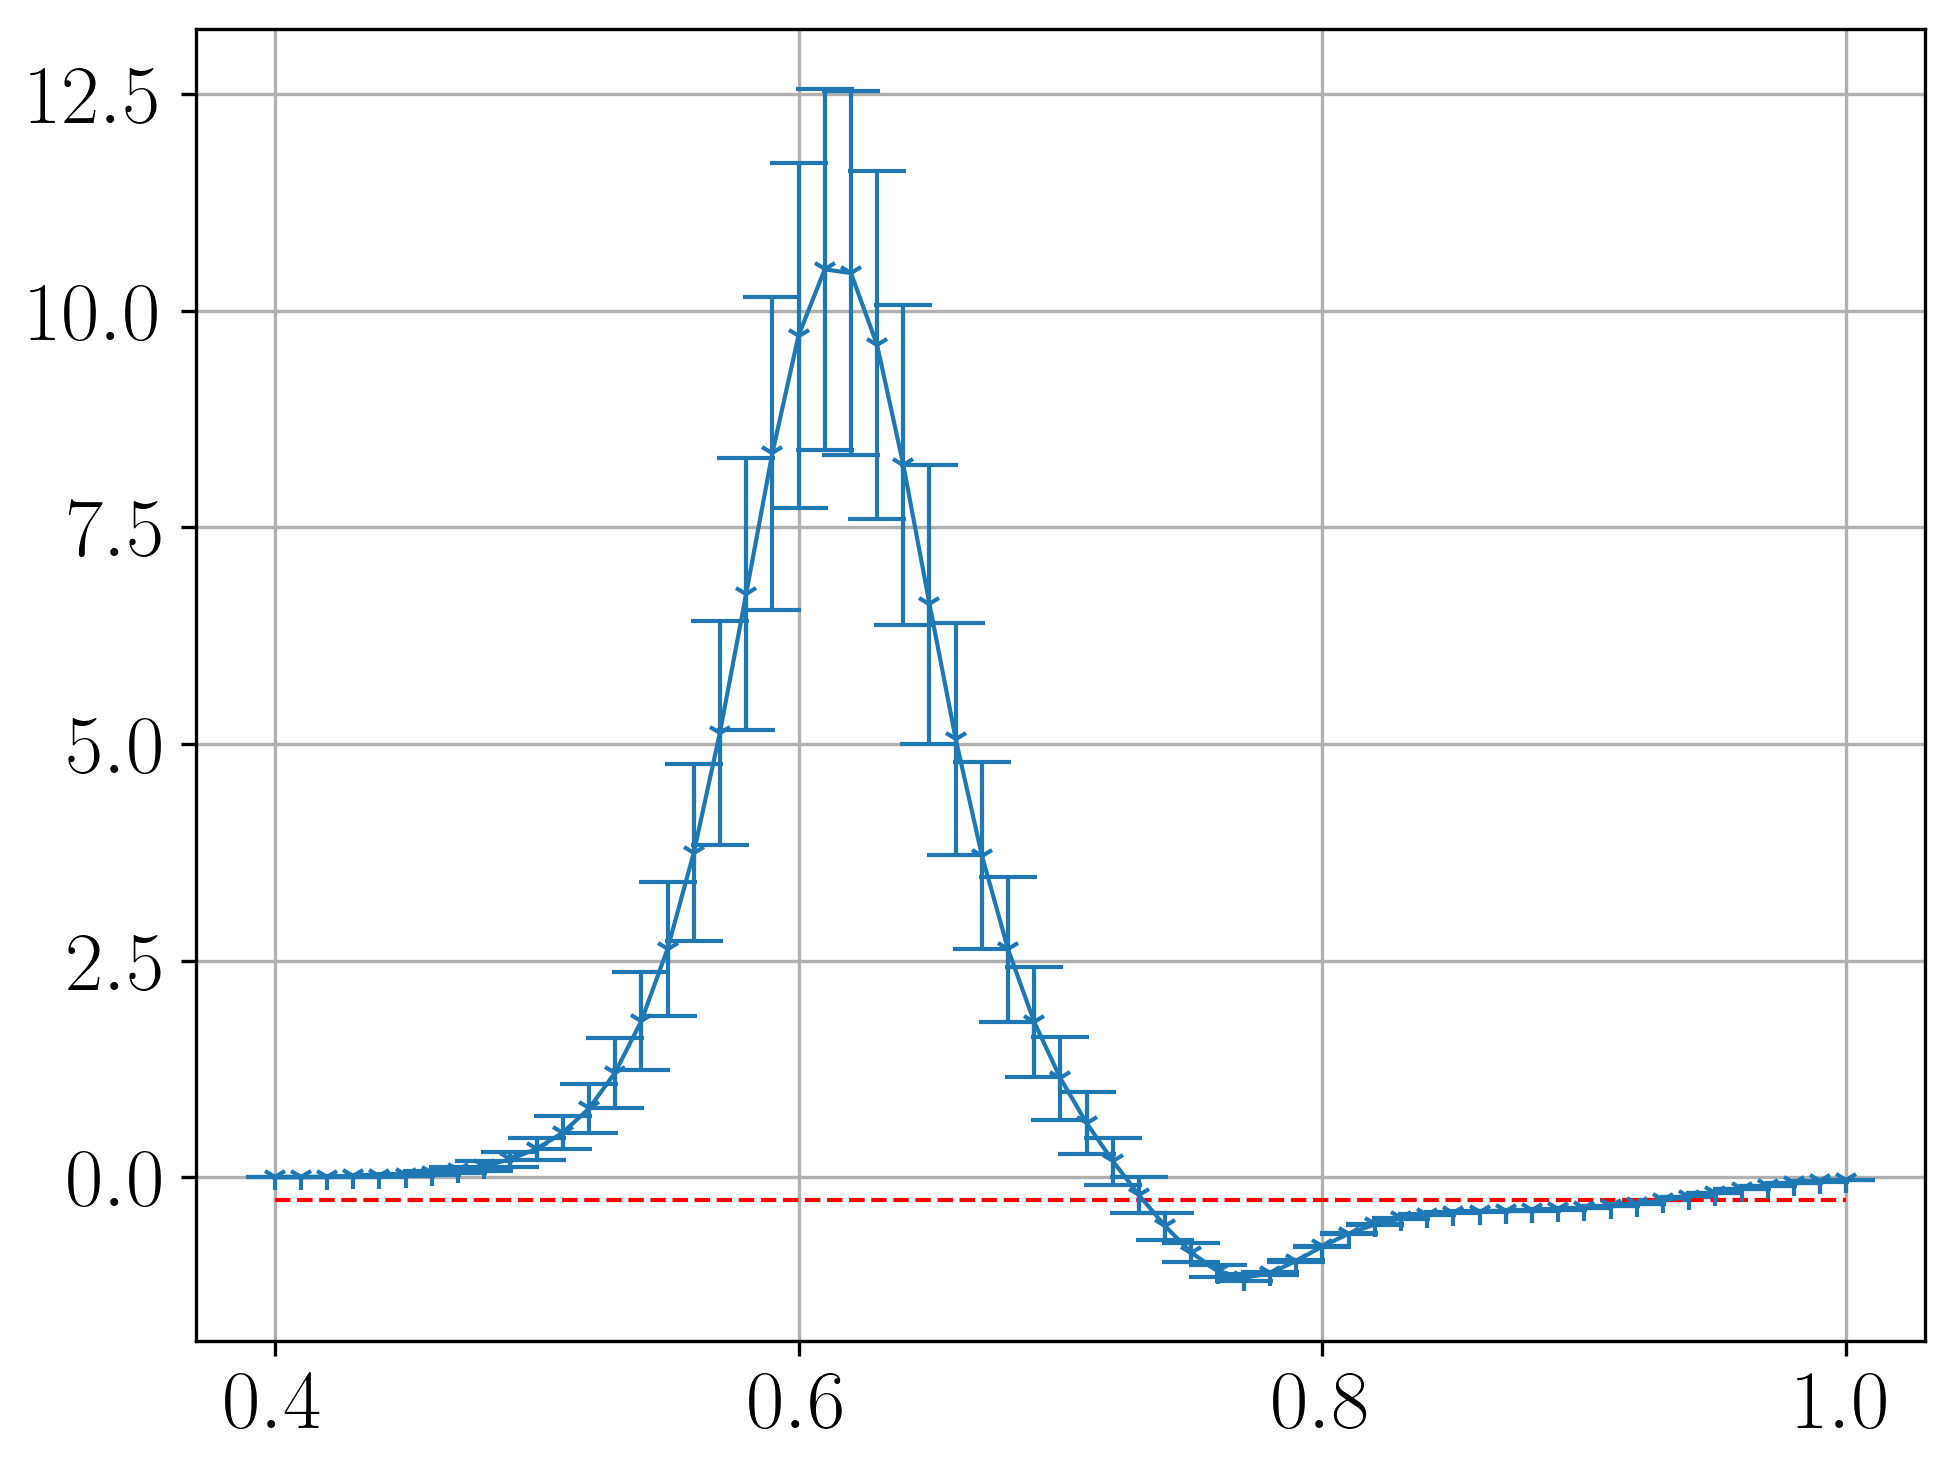

In [327]:
l, L = 3, 30
npoints, h_i, h_f = 61, 0.4, 1.0
interval = np.linspace(h_i,h_f,npoints)
gs = interval
boundcond = "pbc"
chis = [16,32,64]
chi = 64
Rs = [18,20,22,24]

gammas_pbc, gammas_pbc_err = [], []
for g in gs:
    potentials = [static_potential(g,R,l,L,chi) for R in Rs]
    popt, pcov = curve_fit(luscher_fit, Rs, potentials)
    errs = np.sqrt(np.diag(pcov))
    gammas_pbc.append(popt[2])
    gammas_pbc_err.append(errs[2])
# gammas_pbc, gammas_pbc_err = fit_luscher(gs, Rs, l, L, chis)
plt.errorbar(gs, gammas_pbc, yerr=gammas_pbc_err, capsize=7, marker='1', linewidth=1)
plt.hlines(y=-np.pi/12, xmin=gs[0], xmax=gs[-1], linestyles="--", colors='red', linewidth=1)
# plt.plot(gs, gammas_pbc, marker='o')
plt.grid(True)
print(gammas_pbc)

[0.008792400202205675, 0.010093600189535864, 0.011567880103921756, 0.013238837372432278, 0.0151343020579536, 0.017287522726333573, 0.01973879905248648, 0.02253773212377369, 0.025746538252946163, 0.029444100713642007, 0.03373216324642978, 0.03874275647413384, 0.04464745502936085, 0.051667112483050025, 0.06007928814572115, 0.07021751156746914, 0.08245281155614331, 0.0971457575376048, 0.11456453707746986, 0.13478946445262013, 0.15766724369662757, 0.18289614387462058, 0.21024142999334894, 0.2397239744632938, 0.27159666344896644, 0.3061294790117216, 0.34340342556414877, 0.3832495109141688, 0.4253122015026673, 0.46914935914714895, 0.5143135551565512, 0.5603999699681661, 0.6070678945541798, 0.6540530649000672, 0.7011690409087834, 0.7483008375332932, 0.7953692990056893, 0.8422630989674245, 0.8887766529141378, 0.9346258329200123, 0.9795532594705514, 1.0234247771519787, 1.0662361217365968, 1.108058277378053, 1.1489826543600579, 1.1890929384696551, 1.2284565607636004, 1.267125228168328, 1.3051373

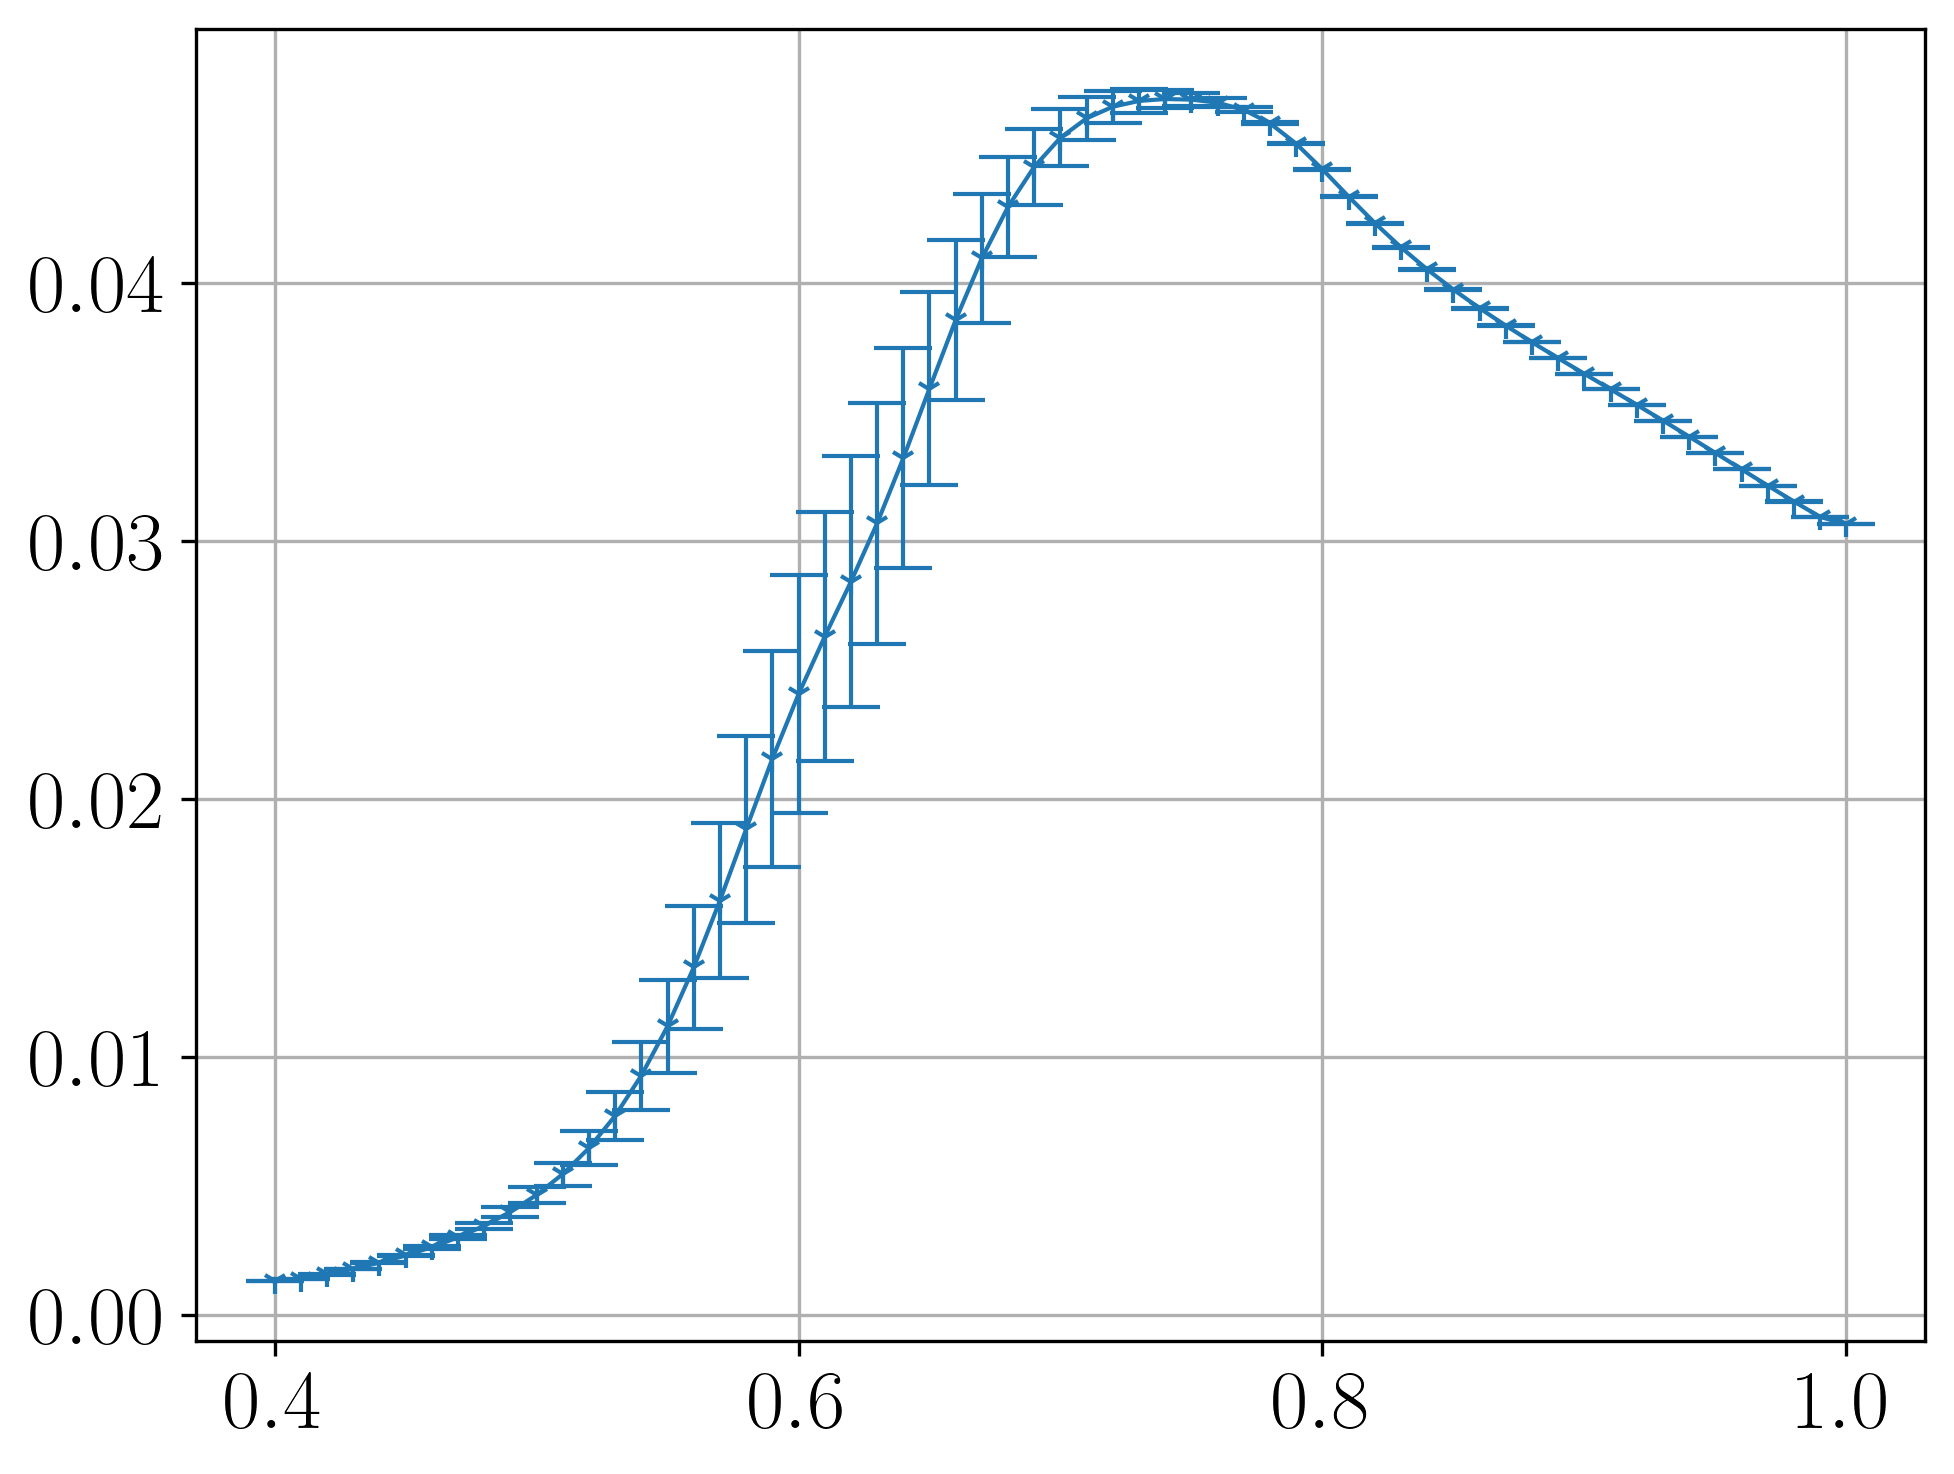

In [328]:
sigmas_pbc, sigmas_pbc_err = [], []
for g in gs:
    potentials = [static_potential(g,R,l,L,chi) for R in Rs]
    popt, pcov = curve_fit(luscher_fit, Rs, potentials)
    errs = np.sqrt(np.diag(pcov))
    sigmas_pbc.append(popt[0])
    sigmas_pbc_err.append(errs[0])
# sigmas_pbc, sigmas_pbc_err = fit_luscher(gs, Rs, l, L, chis)
plt.errorbar(gs, np.gradient(sigmas_pbc), yerr=sigmas_pbc_err, capsize=7, marker='1', linewidth=1)
plt.grid(True)
print(sigmas_pbc)

# Study of the Entropy $S_{vn}(R)$

In [304]:
from qs_mps.utils import von_neumann_entropy

def two_charge_sector_entropy(g,R,l,L,chi,cy=None):
    cx = get_cx(L,R)
    if cy == None:
        cy = get_cy(l)
    try:
        vac = None
        entropy_charges = np.load(f"{path_tensor}/results/entropy_data/{L//2}_schmidt_vals_Z2_dual_direct_lattice_{l}x{L}_{sector}_bc_{boundcond}_{cx}-{cy}_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy")
    except:
        vac = np.nan
        entropy_charges = np.load(f"{path_tensor}/results/entropy_data/{L//2}_schmidt_vals_Z2_dual_direct_lattice_{l}x{L}_{sector}_bc_{boundcond}_{cx}-{cy}_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy")

    for i, val in enumerate(entropy_charges):
        if round(g,3) == round(interval[i],3):
            return val
        
def two_charge_sector_entropy_chis(g,R,l,L,chis,cy=None):
    st_pots = []
    for chi in chis:
        st_pot = two_charge_sector_entropy(g,R,l,L,chi,cy)
        st_pots.append(st_pot)
    return st_pots

def vacuum_sector_entropy(g,R,l,L,chi,cy=None):
    cx = get_cx(L,R)
    if cy == None:
        cy = get_cy(l)
    try:
        vac = None
        entropy_vacuum = np.load(f"{path_tensor}/results/entropy_data/{L//2}_schmidt_vals_Z2_dual_direct_lattice_{l}x{L}_vacuum_sector_bc_{boundcond}_{vac}-{vac}_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy")
    except:
        vac = np.nan
        entropy_vacuum = np.load(f"{path_tensor}/results/entropy_data/{L//2}_schmidt_vals_Z2_dual_direct_lattice_{l}x{L}_vacuum_sector_bc_{boundcond}_{vac}-{vac}_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy")

    for i, val in enumerate(entropy_charges):
        if round(g,3) == round(interval[i],3):
            return val
        
def vacuum_sector_entropy_chis(g,R,l,L,chis,cy=None):
    st_pots = []
    for chi in chis:
        st_pot = vacuum_sector_entropy(g,R,l,L,chi,cy)
        st_pots.append(st_pot)
    return st_pots

In [311]:
chis = [64,128]
chis = [16,32,64,128]
cy = [2,2]
npoints, h_i, h_f = 30, 0.8, 1.0
interval = np.linspace(h_i,h_f,npoints)
gs = interval
l, L = 4, 50
R = 28
boundcond = "pbc"
g = find_closest_value(interval, g)
entropies = two_charge_sector_entropy_chis(g,R,l,L,chis,cy)

we search for g=1.0


<>:3: SyntaxWarning: invalid escape sequence '\c'
<>:5: SyntaxWarning: invalid escape sequence '\c'
<>:3: SyntaxWarning: invalid escape sequence '\c'
<>:5: SyntaxWarning: invalid escape sequence '\c'
/var/folders/d1/c6hqhfn161x458f4d0m3_rm80000gp/T/ipykernel_77609/1660411103.py:3: SyntaxWarning: invalid escape sequence '\c'
  plt.xlabel("$1/\chi$")
/var/folders/d1/c6hqhfn161x458f4d0m3_rm80000gp/T/ipykernel_77609/1660411103.py:5: SyntaxWarning: invalid escape sequence '\c'
  plt.title("Two-charge sector Entropy $S_{vn}^c(g,R,l$x$L)$ $vs$ $1/\chi$")


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (4, 1) + inhomogeneous part.

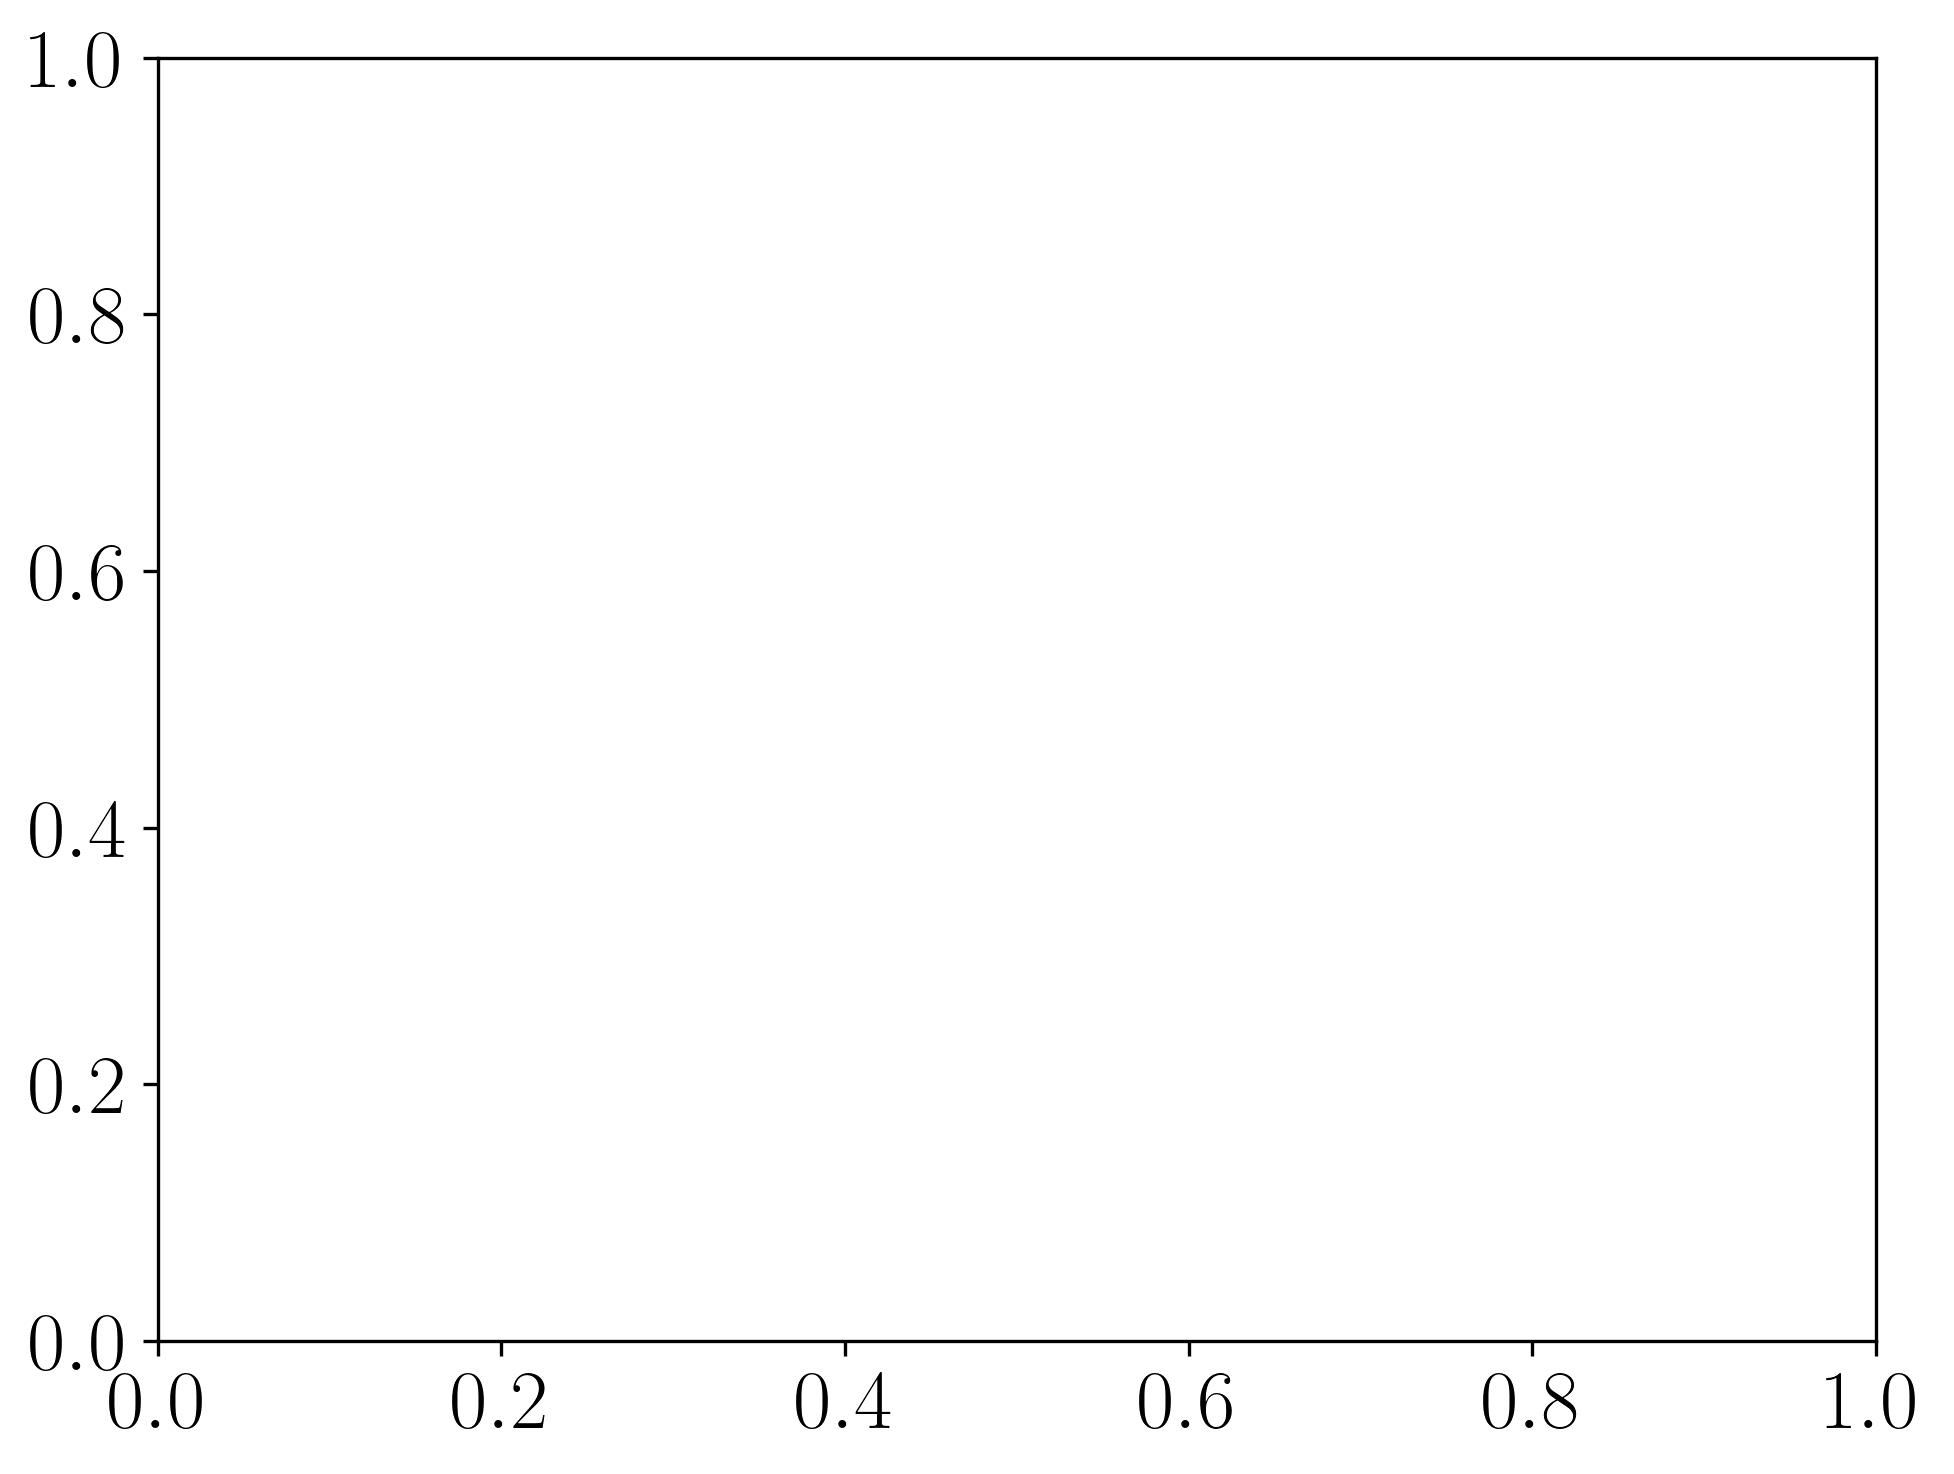

In [312]:
plt.plot([1/chi for chi in chis], entropies, 'x', label=f"$S_{{vn}}^c(g={round(g,2)}, R={R}, l$x$L={l}$x${L})$")

plt.xlabel("$1/\chi$")
plt.ylabel("Entropy $(S_{vn}^c(R))$")
plt.title("Two-charge sector Entropy $S_{vn}^c(g,R,l$x$L)$ $vs$ $1/\chi$")
plt.legend()
plt.grid(True)

In [97]:
def connected_entropy_varying_R(g,Rs,l,L,chi):
    entropies = []
    err_potentials = []
    for R in Rs:
        print(f"R: {R}")
        entr = connected_entropy(g,R,l,L,chi)
        entropies.append(entr)


    return entropies

def connected_entropy_varying_g(gs,R,l,L,chi):
    entropies = []
    for g in gs:
        print(f"g: {g}")
        entr = connected_entropy(g,R,l,L,chi)
        entropies.append(entr)

    return entropies

def bulk_entropy_varying_g(gs,R,l,L,chi):
    entropies = []
    for g in gs:
        print(f"g: {g}")
        entr = bulk_entropy(g,R,l,L,chi)
        entropies.append(entr)

    return entropies

In [98]:
conn_entropies = connected_entropy_varying_g(interval,R,l,L,chis[-1])

g: 0.8
g: 0.806896551724138
g: 0.8137931034482759
g: 0.8206896551724139
g: 0.8275862068965517
g: 0.8344827586206897
g: 0.8413793103448276
g: 0.8482758620689655
g: 0.8551724137931035
g: 0.8620689655172414
g: 0.8689655172413794
g: 0.8758620689655172
g: 0.8827586206896552
g: 0.8896551724137931
g: 0.896551724137931
g: 0.903448275862069
g: 0.9103448275862069
g: 0.9172413793103449
g: 0.9241379310344828
g: 0.9310344827586207
g: 0.9379310344827586
g: 0.9448275862068966
g: 0.9517241379310345
g: 0.9586206896551724
g: 0.9655172413793103
g: 0.9724137931034482
g: 0.9793103448275862
g: 0.9862068965517241
g: 0.993103448275862
g: 1.0


g: 0.8
g: 0.806896551724138
g: 0.8137931034482759
g: 0.8206896551724139
g: 0.8275862068965517
g: 0.8344827586206897
g: 0.8413793103448276
g: 0.8482758620689655
g: 0.8551724137931035
g: 0.8620689655172414
g: 0.8689655172413794
g: 0.8758620689655172
g: 0.8827586206896552
g: 0.8896551724137931
g: 0.896551724137931
g: 0.903448275862069
g: 0.9103448275862069
g: 0.9172413793103449
g: 0.9241379310344828
g: 0.9310344827586207
g: 0.9379310344827586
g: 0.9448275862068966
g: 0.9517241379310345
g: 0.9586206896551724
g: 0.9655172413793103
g: 0.9724137931034482
g: 0.9793103448275862
g: 0.9862068965517241
g: 0.993103448275862
g: 1.0
g: 0.8


FileNotFoundError: [Errno 2] No such file or directory: '/Users/fradm/Desktop/projects/1_Z2/results/entropy_data/25_schmidt_vals_Z2_dual_direct_lattice_5x50_vacuum_sector_bc_pbc_nan-nan_h_0.8-1.0_delta_30_chi_64.npy'

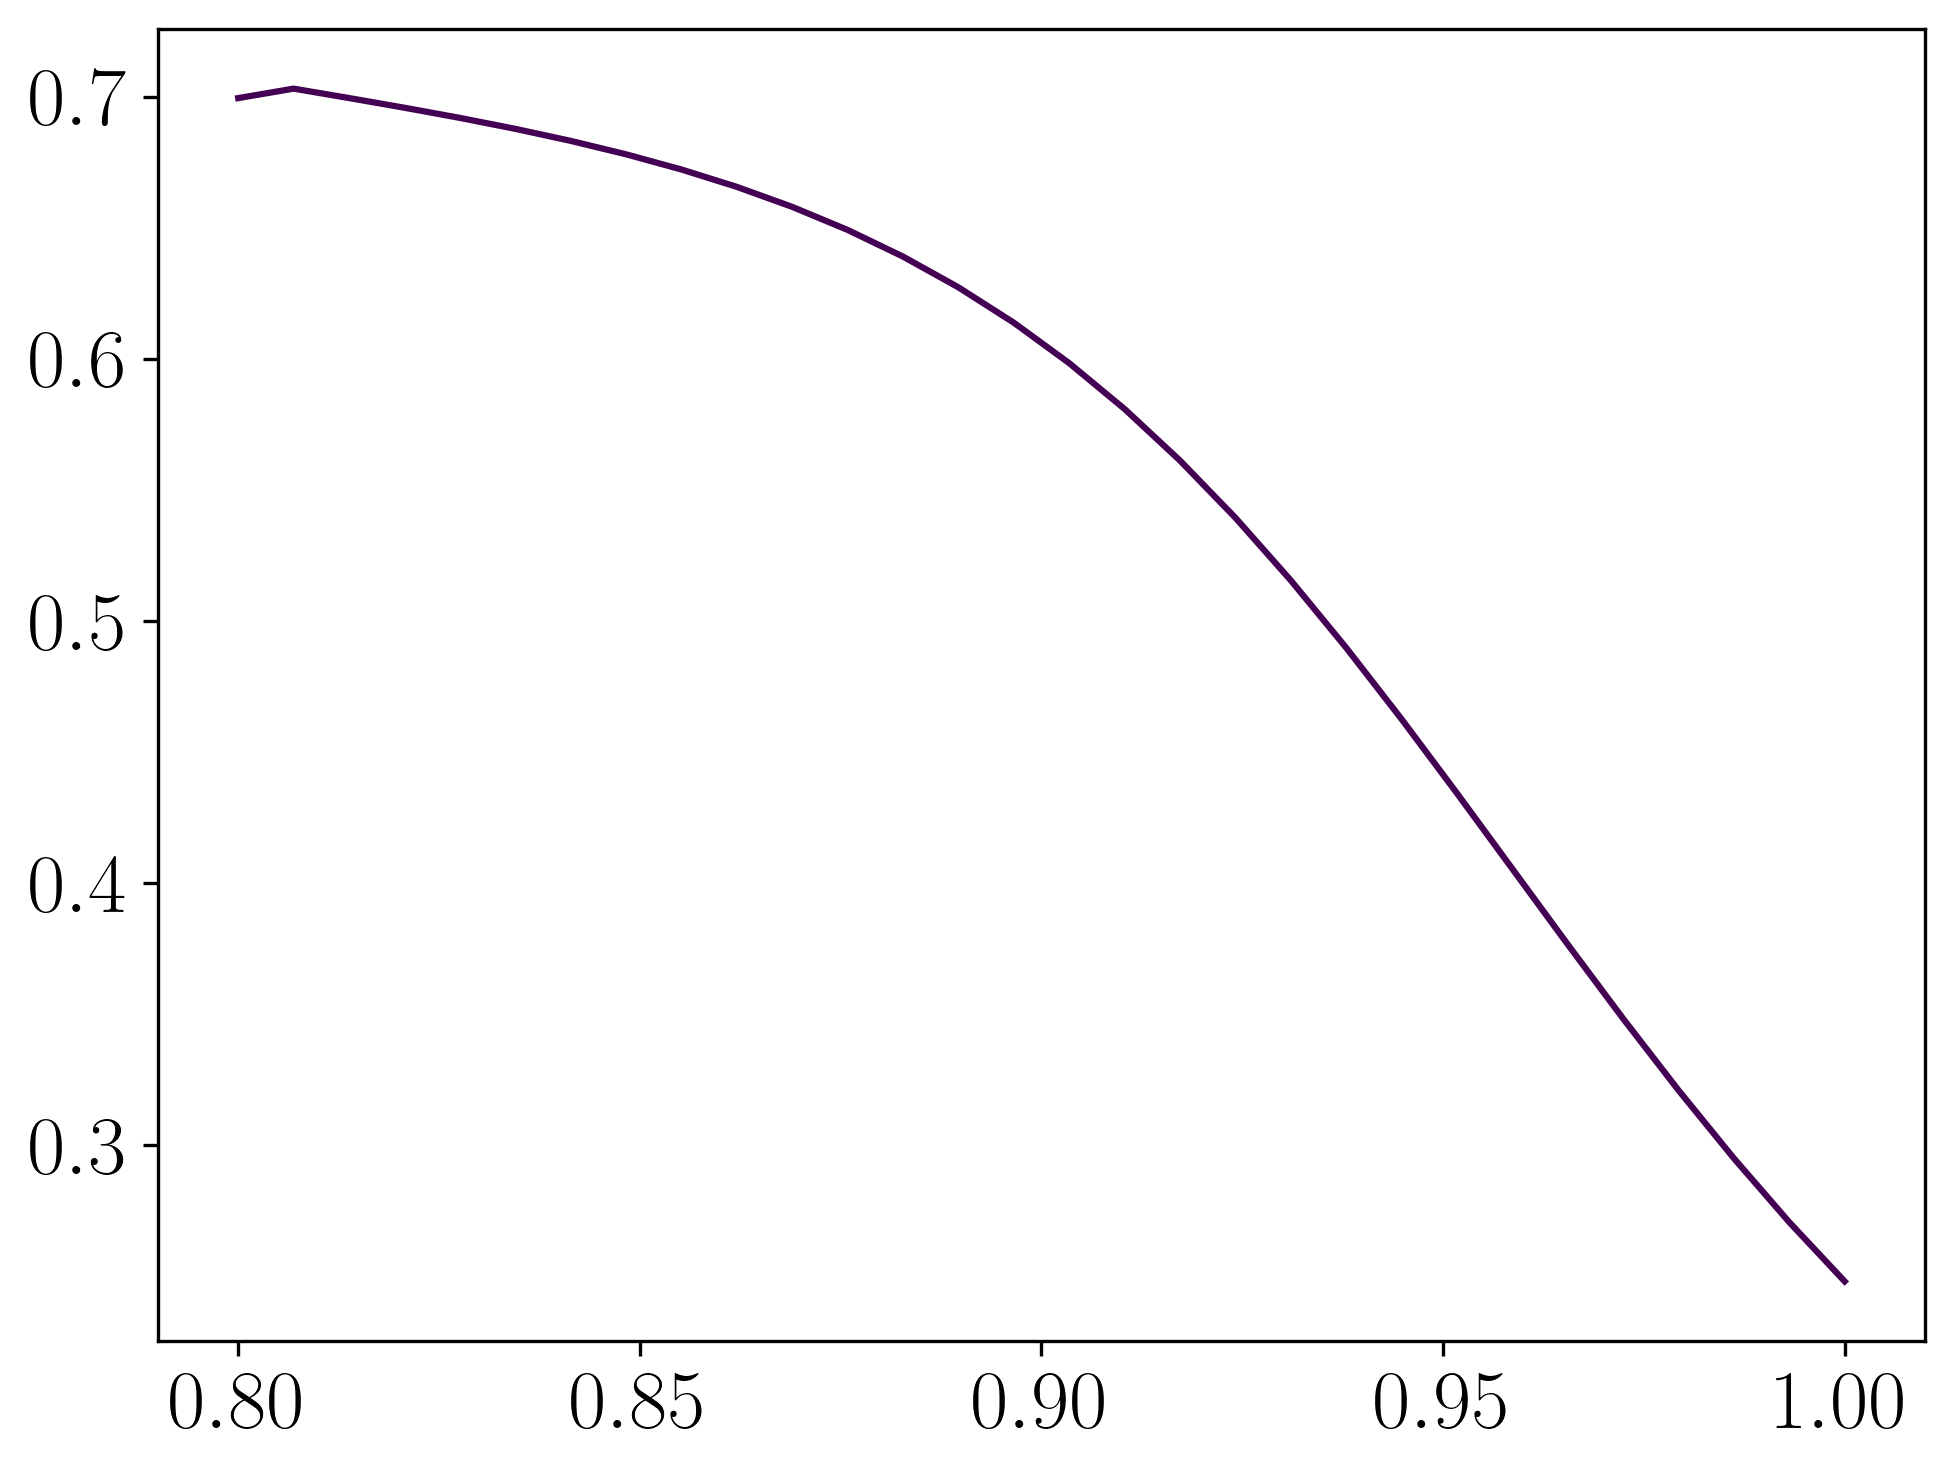

In [92]:
ls = [4,5,6]
colors = create_sequential_colors(len(ls))
boundcond = "pbc"
R = 28
chis = [64]
for i, l in enumerate(ls):
    conn_entropies = connected_entropy_varying_g(interval,R,l,L,chis[-1])
    plt.plot(interval, conn_entropies, color=colors[i], label=f"lxL:{l}x{L}")
plt.grid(True)
plt.legend()

g: 0.8
g: 0.806896551724138
g: 0.8137931034482759
g: 0.8206896551724139
g: 0.8275862068965517
g: 0.8344827586206897
g: 0.8413793103448276
g: 0.8482758620689655
g: 0.8551724137931035
g: 0.8620689655172414
g: 0.8689655172413794
g: 0.8758620689655172
g: 0.8827586206896552
g: 0.8896551724137931
g: 0.896551724137931
g: 0.903448275862069
g: 0.9103448275862069
g: 0.9172413793103449
g: 0.9241379310344828
g: 0.9310344827586207
g: 0.9379310344827586
g: 0.9448275862068966
g: 0.9517241379310345
g: 0.9586206896551724
g: 0.9655172413793103
g: 0.9724137931034482
g: 0.9793103448275862
g: 0.9862068965517241
g: 0.993103448275862
g: 1.0
g: 0.8
g: 0.806896551724138
g: 0.8137931034482759
g: 0.8206896551724139
g: 0.8275862068965517
g: 0.8344827586206897
g: 0.8413793103448276
g: 0.8482758620689655
g: 0.8551724137931035
g: 0.8620689655172414
g: 0.8689655172413794
g: 0.8758620689655172
g: 0.8827586206896552
g: 0.8896551724137931
g: 0.896551724137931
g: 0.903448275862069
g: 0.9103448275862069
g: 0.9172413793103

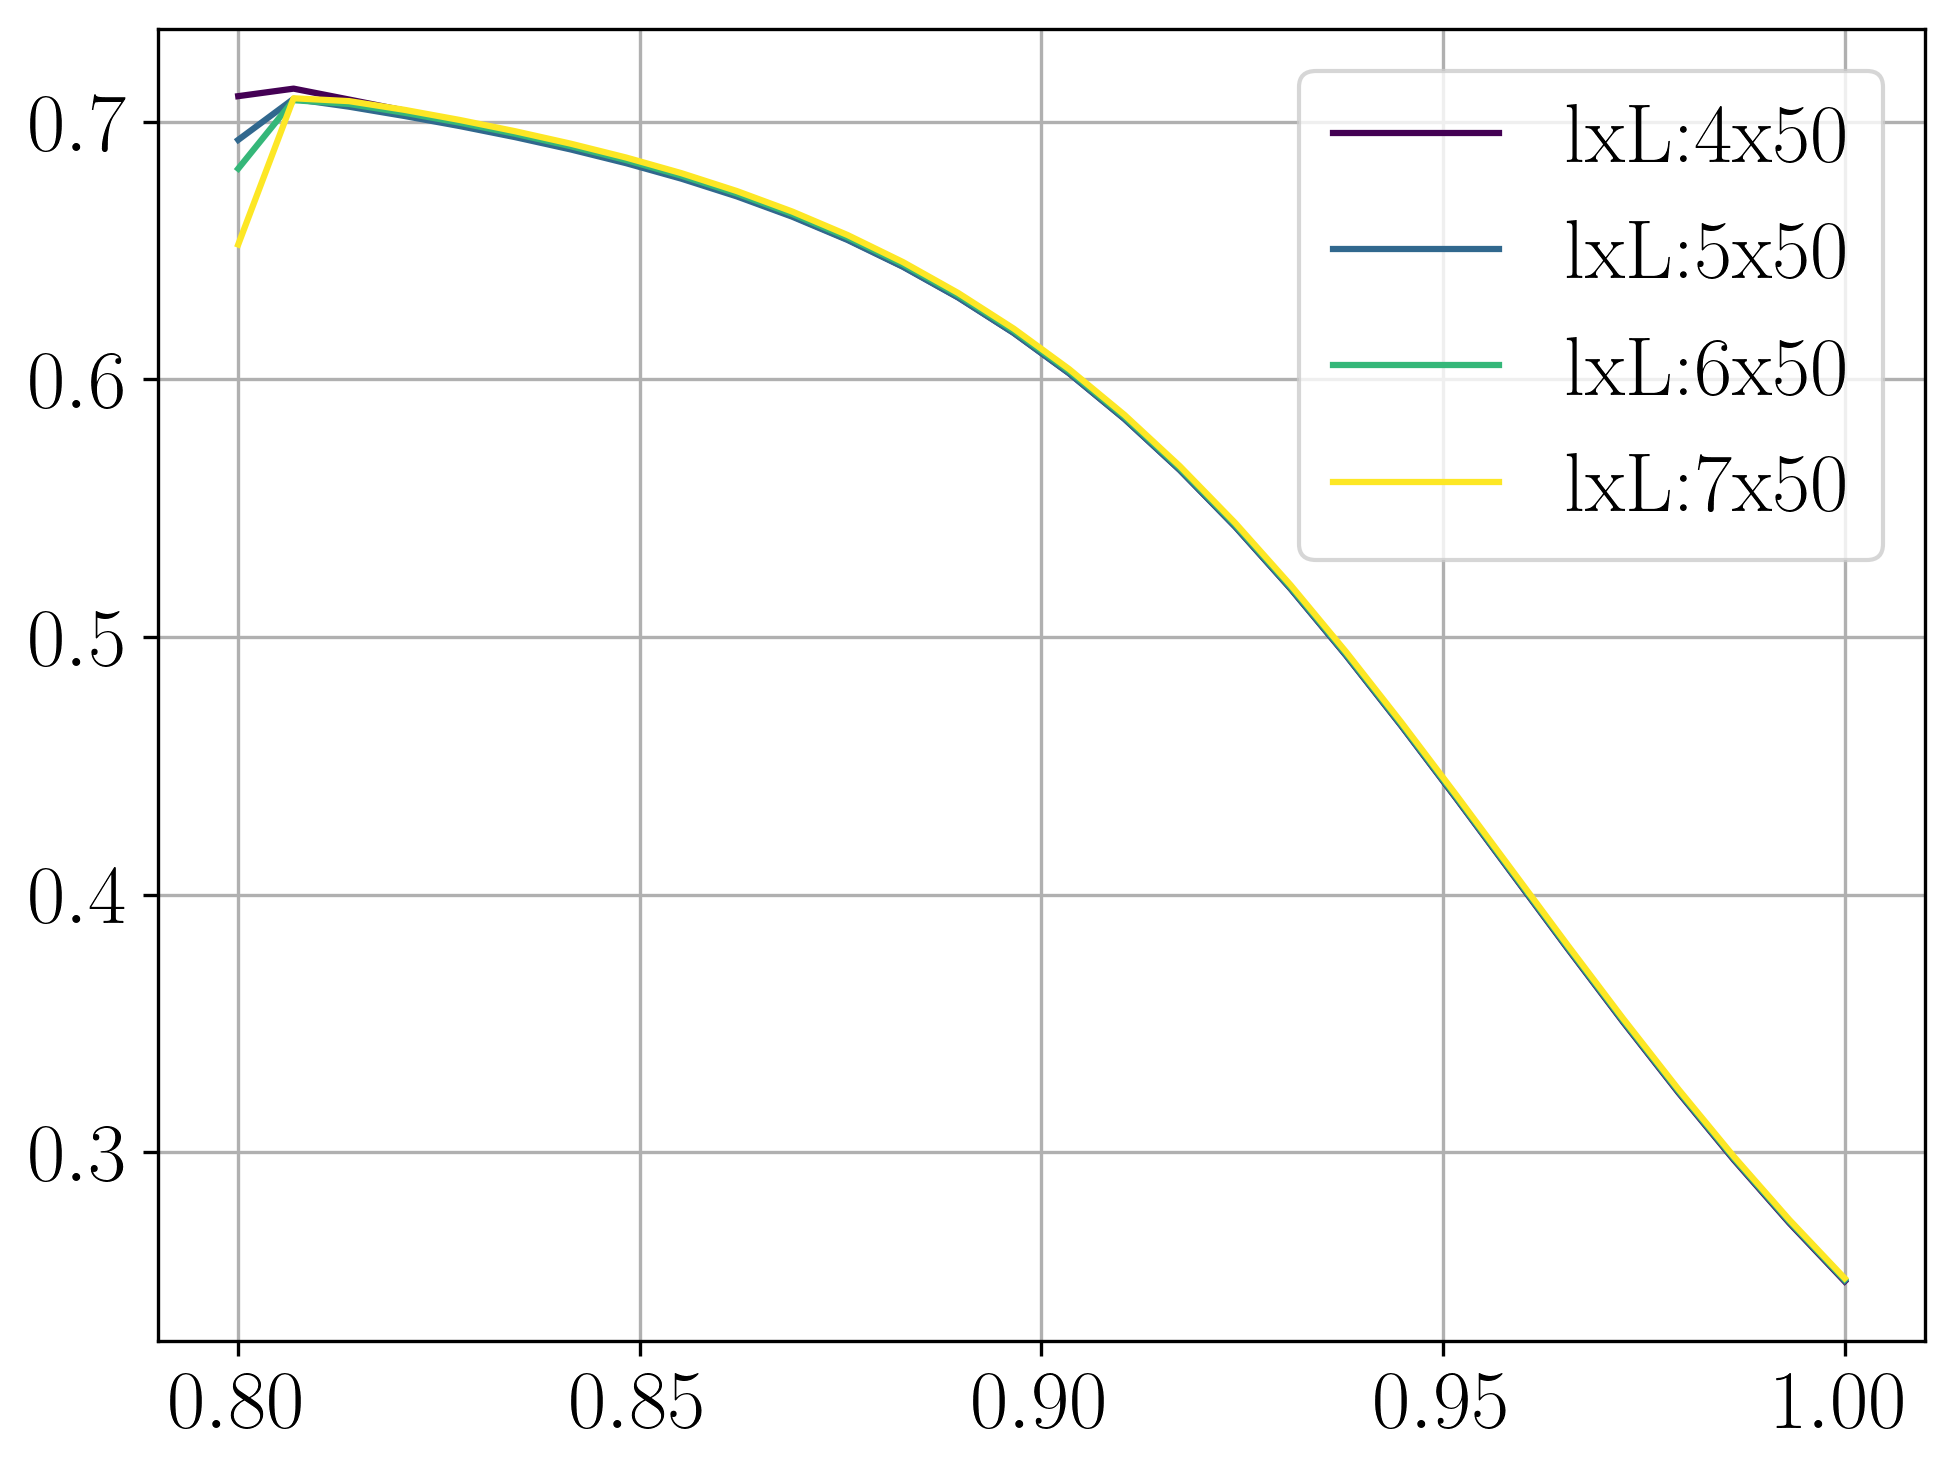

In [99]:
ls = [4,5,6,7]
colors = create_sequential_colors(len(ls))
boundcond = "pbc"
R = 28
chis = [64]
for i, l in enumerate(ls):
    bulk_entropies = bulk_entropy_varying_g(interval,R,l,L,chis[-1])
    plt.plot(interval, bulk_entropies, color=colors[i], label=f"lxL:{l}x{L}")
plt.grid(True)
plt.legend()